Initial run for Isabel's Data
=================

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display
import math

from lda_for_fragments import Ms2Lda

<h2>Analysis</h2>

<h3>a. Run LDA</h3>

In [2]:
fragment_filename = 'isabelpos_fragments.csv'
neutral_loss_filename = 'isabelpos_losses.csv'
mzdiff_filename = None
ms1_filename = 'isabelpos_ms1.csv'
ms2_filename = 'isabelpos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

Loading input files
Data shape (435, 1108)


In [3]:
### all the parameters you need to specify to run LDA ###

n_topics = 100
n_samples = 1000
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in. Ignored if n_burn = 0
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

Fitting model...
CGS LDA initialising
............................................
Using Numba for LDA sampling
Preparing words
Preparing Z matrix
DONE
Sample 1   Log likelihood = -1461466.853 
Sample 2   Log likelihood = -1042352.717 
Sample 3   Log likelihood = -728233.192 
Sample 4   Log likelihood = -615263.063 
Sample 5   Log likelihood = -575765.339 
Sample 6   Log likelihood = -556139.565 
Sample 7   Log likelihood = -544430.841 
Sample 8   Log likelihood = -534607.046 
Sample 9   Log likelihood = -528740.628 
Sample 10   Log likelihood = -522917.197 
Sample 11   Log likelihood = -518421.127 
Sample 12   Log likelihood = -515177.828 
Sample 13   Log likelihood = -513795.819 
Sample 14   Log likelihood = -512253.379 
Sample 15   Log likelihood = -509922.274 
Sample 16   Log likelihood = -507959.845 
Sample 17   Log likelihood = -506629.517 
Sample 18   Log likelihood = -505258.369 
Sample 19   Log likelihood = -503907.724 
Sample 20   Log likelihood = -502951.820 
Sample 21   Log

<h3>b. Annotations</h3>

In [4]:
sirius_platform = 'orbitrap'
ms2lda.annotate_with_sirius(sirius_platform, mode='pos', max_ms1=9999) # mode is either 'pos' or 'neg'

Running SIRIUS annotation with parameters:
- platform = orbitrap
- mode = pos
- ppm_max = 5
- min_score = 0.01
- max_ms1 = 9999

    1/  435 pID  452 m/z 385.18096 int 8.1252e+05 n_frags  5	ACCEPT	3 fragment(s) annotated with score 12.63
    2/  435 pID  631 m/z 513.25313 int 8.3645e+05 n_frags  1	ACCEPT	0 fragment(s) annotated with score 0.20
    3/  435 pID  672 m/z 358.25877 int 6.2059e+05 n_frags  9	ACCEPT	6 fragment(s) annotated with score 21.38
    4/  435 pID  693 m/z 391.25098 int 7.0632e+05 n_frags 13	ACCEPT	10 fragment(s) annotated with score 21.22
    5/  435 pID  701 m/z 763.38784 int 3.0677e+06 n_frags  5	ACCEPT	4 fragment(s) annotated with score 1.63
    6/  435 pID  716 m/z 742.45888 int 1.7964e+06 n_frags  7	ACCEPT	5 fragment(s) annotated with score 9.68
    7/  435 pID  718 m/z 880.59025 int 8.6466e+05 n_frags  5	ACCEPT	5 fragment(s) annotated with score 2.88
    8/  435 pID  723 m/z 312.21684 int 7.1932e+05 n_frags 16	ACCEPT	14 fragment(s) annotated with score 50.33
 

In [15]:
ms2lda = Ms2Lda.resume_from('isabel.project')

ERROR! Session/line number was not unique in database. History logging moved to new session 95
Project loaded from isabel.project time taken = 5.69303417206
 - input_filenames = 
	isabelpos_fragments.csv
	isabelpos_losses.csv
	isabelpos_ms1.csv
	isabelpos_ms2.csv
 - df.shape = (435, 1108)
 - K = 100
 - alpha = 0.5
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Thu Oct  8 18:19:16 2015
 - message = Initial run on Isabel data by Joe


In [16]:
proton_mass = 1.00727645199076

# peaklist_filename = 'peaklist_POS.csv'
peaklist_filename = 'sanitized_ideom_output.csv'
peaklist = pd.read_csv(peaklist_filename)
annot = peaklist[['mz', 'rt', 'int', 'metabolite','AN3967']]
# annot = annot[pd.notnull(annot['Metabolite'])] # drop NaN metabolites


label_len = 20
mass_tol = 10
rt_tol = 120

# for each row in the IDIOM annotation results 
total_match = 0
for row in annot.itertuples():
    
    # get mz, rt, intensity and the putative metabolite identity
    mz = row[1] + proton_mass
    rt = row[2]
    intensity = row[3]
    label = row[4]
    fold_change = row[5]
    print fold_change
    
    # truncate long metabolite names
#     label = (label[:label_len] + '..') if len(label) > label_len else label    
    print "Processing " + str((mz, rt, intensity)) + " " + str(label)

    # find matching MS1 within mass_tol and rt_tol
    interval = mz*mass_tol*1e-6
    mass_start, mass_end = (mz-interval, mz+interval)
    rt_start, rt_end = (rt-rt_tol, rt+rt_tol)
    
    match_mass = (ms2lda.ms1.mz>mass_start) & (ms2lda.ms1.mz<mass_end)
    match_rt = (ms2lda.ms1.rt>rt_start) & (ms2lda.ms1.rt<rt_end)
    match = match_mass & match_rt
    
    res = ms2lda.ms1[match]
    if len(res) == 1:

        # if only 1 match, immediately annotate
        print "Found 1 hit"
        idx = res.index[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        ms2lda.ms1.loc[[idx], 'fold_change'] = fold_change
        display(res)
        total_match += 1

    elif len(res) > 0:

        print "Found %d hits" % len(res)        
        
        # if multiple matches, find the closest in RT   
        closest = None
        min_dist = sys.maxint
        for match_res in res.itertuples():
            match_rt = match_res[4]
            match_mz = match_res[5]
            dist = math.sqrt((match_rt-rt)**2 + (match_mz-mz)**2)
            if dist < min_dist:
                min_dist = dist
                closest = match_res

        idx = closest[0]
        ms2lda.ms1.loc[[idx], 'annotation'] = label
        ms2lda.ms1.loc[[idx], 'fold_change'] = fold_change
        display(res)
        total_match += 1        
        
    print
    
print "total_match=" + str(total_match) + "/" + str(annot.shape[0])

1.368748722
Processing (71.085536421990767, 232.57195980000003, 34996) nan

0.868235209
Processing (74.023649131990766, 695.99287670000012, 3532) Iminoglycine

1.113429793
Processing (74.060028581990764, 595.91434649999997, 48715) Aminoacetone
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3888,3888,0,1,508.189,74.060018,1482000.625,1,20,0,C3H7NO
5502,5502,0,1,615.361,74.060035,4867594.000,1,0,0,Aminoacetone



0.68791844
Processing (76.039059521990765, 1356.103124, 29573) nan

0.894622564
Processing (76.039295691990759, 822.14852840000003, 245819) Glycine

0.904590532
Processing (76.075680391990758, 648.14350860000002, 57397) (R)-1-Aminopropan-2-ol

0.836198865
Processing (77.008135031990761, 1380.0902100000001, 22659) nan

0.925434779
Processing (77.023065081990765, 410.51318800000001, 757550) nan

1.091742697
Processing (77.649609521990769, 257.633667, 2485) nan

1.323661962
Processing (78.099681331990766, 256.86133239999998, 6149) nan

0.981093188
Processing (78.211064611990764, 253.77637510000002, 14225) nan

0.746185368
Processing (78.984402421990765, 1287.2287550000001, 8819) nan

1.776971215
Processing (79.021203161990769, 408.629795, 130333) nan

2.649251869
Processing (79.021206391990759, 5.9989650879999994, 109253) nan

0.70266404
Processing (80.933275081990757, 717.23124689999997, 42302) Br-

0.593241828
Processing (80.947727751990755, 721.29287470000008, 16973) nan

0.949488059


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3606,3606,0,1,536.499,86.096339,15411655,1,0,0,C5H11N,NaN
3607,3607,0,1,521.822,86.096340,11351523,1,77,0,C5H11N,NaN



0.762440997
Processing (87.043988721990758, 655.28750100000002, 4522) 2-Butenoate

0.810606744
Processing (87.044030321990761, 794.88474659999997, 56969) Diacetyl

0.834718335
Processing (87.091696071990768, 1231.804695, 166322) nan

1.166927607
Processing (87.10241521199076, 644.7585004, 3004) nan

0.63686087
Processing (88.039292101990767, 801.01649860000009, 15314) 2-Aminoacrylate

0.796587253
Processing (89.023254561990768, 462.82610319999998, 2810079) Pyruvate

0.529880692
Processing (89.023315021990769, 784.43687179999995, 352474) 3-Oxopropanoate

0.779632805
Processing (90.018562751990757, 729.32312390000004, 13831) Oxamate

0.903894465
Processing (90.054894181990761, 791.51574579999999, 10722286) L-Alanine

0.337975461
Processing (90.054958671990761, 1336.0123390000001, 391083) Sarcosine

0.429384679
Processing (90.054959461990762, 1162.7030600000001, 185944) Sarcosine

0.268418973
Processing (90.054974261990765, 1243.8015809999999, 450100) D-Alanine

0.807066861
Processing (9

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6525,6525,0,1,646.69,104.070598,11221028,1,0,0,4-Aminobutanoate,NaN



1.226451641
Processing (104.10688495199076, 1155.3761259999999, 28949832) Choline

0.977521648
Processing (105.00044105199076, 225.79716299999998, 6931) nan

0.964946933
Processing (105.01823585199077, 798.06350199999997, 9988) 2-Hydroxy-3-oxopropanoate

0.7915222
Processing (105.02951435199077, 642.83687459999999, 35344) Urea-1-carboxylate

0.750712809
Processing (105.05460145199076, 452.55541360000001, 5750) (R)-3-Hydroxybutanoate

4.518050761
Processing (105.35036495199077, 279.13177139999999, 2474) nan

0.747666641
Processing (106.01350945199077, 757.83637239999996, 3998) nan

0.579276704
Processing (106.04984535199077, 820.65875240000003, 1305799) L-Serine

0.972808143
Processing (106.08618645199077, 653.40012279999996, 3484) Diethanolamine

0.676571924
Processing (107.01462645199076, 1313.1862640000002, 12007) nan

0.68612695
Processing (107.01462725199076, 1158.5352150000001, 22408) nan

0.987891117
Processing (107.03381265199076, 809.78719120000005, 11242) L-Glycericacid

0.60

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3584,3584,0,1,496.476,114.066183,375707808,1,247,0,Creatinine,NaN



0.964588423
Processing (114.73356595199077, 720.97424699999999, 4310) nan

0.870761997
Processing (114.84262395199077, 720.65380449999998, 5214) nan

0.97295382
Processing (114.93338925199076, 721.25967489999994, 5050) nan

0.884912469
Processing (114.97483685199077, 721.43945680000002, 4597) nan

0.665914005
Processing (115.01394345199076, 726.24999870000011, 8904) parabanate

0.621234875
Processing (115.03897405199076, 794.34724679999999, 508504) 2-Hydroxy-2,4-pentadienoate

0.858776177
Processing (115.05023975199076, 476.2537289, 11747) 5,6-Dihydrouracil

0.744903254
Processing (116.03424305199076, 434.65248169999995, 38202) Maleamate

0.844319134
Processing (116.07038145199077, 721.79277569999999, 35457812) L-Proline
Found 7 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6581,6581,0,1,675.195,116.070605,42657660,1,0,0,C5H9NO2,NaN
6582,6582,0,1,799.523,116.070604,20779760,1,0,0,C5H9NO2,NaN
6583,6583,0,1,645.711,116.070626,52252268,1,0,0,C5H9NO2,NaN
6584,6584,0,1,619.300,116.070634,72310528,1,269,0,C5H9NO2,NaN
6585,6585,0,1,745.862,116.070609,20780818,1,0,0,C5H9NO2,NaN
6586,6586,0,1,713.896,116.070599,26674006,1,0,0,C5H9NO2,NaN
6587,6587,0,1,727.950,116.070602,23084028,1,265,0,L-Proline,NaN



0.389854238
Processing (116.07063315199076, 1224.182086, 62654) D-Proline

0.496684985
Processing (116.07064585199078, 1365.0393750000001, 66221) D-Proline

0.720666758
Processing (116.07066205199075, 966.77351639999995, 19938) 3-acetamidopropanal
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6580,6580,0,1,900.49,116.07061,14116196,1,0,0,3-acetamidopropanal,NaN



1.353611874
Processing (116.10689675199076, 1169.743271, 9144) Trimethylaminoacetone

0.740105572
Processing (117.05462725199075, 292.13012569999995, 381491) ethylpyruvate

0.960910481
Processing (117.05464575199076, 453.41699789999996, 66694) 3-Methyl-2-oxobutanoic acid

1.040781416
Processing (117.09098725199077, 280.76697730000001, 117499) 4-Hydroxyhexan-3-one

1.010469551
Processing (118.04987205199076, 727.3482512999999, 29622) L-2-Amino-3-oxobutanoic acid

0.300366926
Processing (118.04991035199077, 1357.404368, 26647) L-Aspartate 4-semialdehyde

0.968341839
Processing (118.06106095199075, 835.04537460000006, 10335) Guanidinoacetate

0.853274917
Processing (118.08618255199076, 660.44130660000008, 10669920) L-Valine

0.272093125
Processing (118.08630485199076, 1330.077098, 116145) 5-Aminopentanoate

0.719516534
Processing (118.08630755199076, 1050.1031109999999, 23430) 4-Methylaminobutyrate

0.170969232
Processing (118.08631445199075, 1131.3297669999999, 82157) Betaine

0.9069809

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5460,5460,0,1,746.861,120.065537,7492794.0,1,0,0,L-Threonine,NaN
5464,5464,0,1,853.359,120.065547,4348642.5,1,299,0,C4H9NO3,NaN
5467,5467,0,1,727.950,120.065534,8346126.0,1,0,0,C4H9NO3,NaN



0.760284734
Processing (120.09015915199076, 694.48112489999994, 38823) nan

0.546143845
Processing (121.04946385199077, 792.95036950000008, 287062) D-Erythrose

0.416163907
Processing (122.02696035199078, 808.34137220000002, 22400) L-Cysteine

1.135712592
Processing (122.08112635199078, 829.49130439999999, 101718) nan

1.73661641
Processing (123.01097885199076, 725.51837539999997, 42097) 3-Mercaptolactate

0.820518724
Processing (123.04020255199076, 1157.9771310000001, 18147) nan

0.796682832
Processing (123.04030205199076, 1351.6808210000002, 18686) nan

1.017099751
Processing (123.05519515199076, 736.52988229999994, 103363) Picolinamide

1.0093581
Processing (123.05524425199077, 452.289671, 2703426) Nicotinamide
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2987,2987,0,1,423.639,123.055482,72183136,1,325,0,Nicotinamide,NaN
2988,2988,0,1,393.783,123.055315,8091679,1,0,0,C6H6N2O,NaN



0.760912118
Processing (124.03930865199075, 341.03232750000001, 9748) nan

1.074842096
Processing (124.99037315199075, 639.33087289999992, 2715) Sulfoacetaldehyde

0.974153483
Processing (125.91659575199076, 234.94310540000001, 10661) nan

0.938704705
Processing (125.91667065199077, 596.24033099999997, 21451) nan

1.040477424
Processing (126.02185375199076, 790.37787249999997, 98152) Taurine

1.111609746
Processing (126.05492135199077, 809.72277459999998, 3826) N-Ethylmaleimide

1.006964917
Processing (127.00594515199076, 620.46399689999998, 6998) 2-Hydroxyethanesulfonate

1.282010283
Processing (127.01561995199077, 752.84487410000008, 4840) 2-Hydroxyethylphosphonate

1.053824018
Processing (127.05008815199078, 650.83775360000004, 6772) nan

0.923068089
Processing (127.05018965199076, 453.04281169999996, 1023040) Thymine

1.144884673
Processing (127.07266425199076, 685.88167150000004, 39497) nan

0.785690024
Processing (128.07049945199074, 734.87020810000001, 37646) 2,3,4,5-Tetrahydro

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4051,4051,0,1,588.752,130.049907,8791941,1,0,0,L-1-Pyrroline-3-hydr..,NaN
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,1-Pyrroline-4-hydrox..,NaN



0.469436065
Processing (130.04992005199074, 1346.126663, 78629) L-1-Pyrroline-3-hydroxy-5-carboxylate

0.635071523
Processing (130.04992045199074, 727.23800019999999, 365107) 1-Pyrroline-4-hydroxy-2-carboxylate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5124,5124,0,1,631.032,130.049991,141326192,1,384,0,1-Pyrroline-4-hydrox..,NaN



1.084289439
Processing (130.08624725199073, 376.55010110000006, 15640) N4-Acetylaminobutanal
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2996,2996,0,1,422.672,130.086465,32309230,1,0,0,N4-Acetylaminobutana..,NaN



0.698746633
Processing (130.08629515199075, 657.66379589999997, 23063) L-Pipecolate

0.796982015
Processing (130.56476605199074, 18.438125549999999, 1719) nan

0.714974163
Processing (131.07026255199074, 275.20387779999999, 1445290) Ethyl 3-oxobutanoate

1.448904479
Processing (131.10659185199077, 245.01761329999999, 130670) Ethyl isovalerate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1730,1730,0,1,233.054,131.106733,6087012.5,1,0,0,Ethyl isovalerate,NaN



0.166951516
Processing (131.11789715199075, 1008.1326529999999, 836606) N-Acetylputrescine

0.798172133
Processing (132.06544835199074, 778.08697760000007, 279470) L-Glutamate 5-semialdehyde

0.927307392
Processing (132.07663215199076, 789.35853170000007, 1384626) Creatine

0.939855923
Processing (132.10182465199077, 642.7185283, 13927689) L-Leucine
Found 6 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5469,5469,0,1,536.499,132.101811,779540288,1,0,0,C6H13NO2,NaN
5470,5470,0,1,662.381,132.101916,11527977,1,0,0,L-Leucine,NaN
5473,5473,0,1,577.922,132.101847,42287180,1,0,0,C6H13NO2,NaN
5474,5474,0,1,596.643,132.101970,22142220,1,0,0,C6H13NO2,NaN
5475,5475,0,1,616.326,132.101936,15396839,1,411,0,C6H13NO2,NaN
5478,5478,0,1,559.155,132.101890,72350496,1,0,0,C6H13NO2,NaN



0.472740123
Processing (132.10185485199074, 824.67204410000011, 223295) L-Isoleucine

0.898233195
Processing (132.10188355199074, 1243.8897830000001, 259898) (3R)-beta-Leucine

0.208840121
Processing (132.10191925199075, 1120.8412499999999, 204356) 6-Aminohexanoate

0.754753671
Processing (132.96854255199074, 598.25771699999996, 3499) nan

0.750622415
Processing (133.04958445199077, 795.93199670000001, 166889) 2-Acetolactate

0.484068478
Processing (133.06072505199074, 797.86412810000002, 1159831) L-Asparagine

1.755698723
Processing (133.08585705199073, 288.60604030000002, 90735) [FA hydroxy(6:0)] 4-hydroxy-hexanoic acid

2.273988825
Processing (133.09714525199075, 1096.1304259999999, 266030) L-Ornithine

0.859881132
Processing (134.02697955199073, 489.04977230000003, 52082) L-thiazolidine-4-carboxylate

0.799829471
Processing (134.04474425199075, 773.50199759999998, 439978) L-Aspartate

2.206920565
Processing (134.08110415199076, 422.50477570000004, 314766) N-hydroxyvaline
Found 3 h

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2998,2998,0,1,422.672,134.081333,117679688,1,0,0,N-hydroxyvaline,NaN
3000,3000,0,1,392.789,134.081204,15000716,1,0,0,C5H11NO3,NaN
3002,3002,0,1,378.860,134.081253,9669711,1,432,0,C5H11NO3,NaN



1.2258878
Processing (134.11750885199075, 850.18322879999982, 9950) nan

0.454878091
Processing (134.45433065199077, 1163.334288, 30396) nan

0.429074445
Processing (134.45436545199072, 1048.9670199999998, 29502) nan

0.358766618
Processing (134.45437605199075, 954.08289820000005, 25328) nan

0.493945414
Processing (134.45437915199074, 1252.5293839999999, 22205) nan

0.612294294
Processing (135.02876285199076, 804.29762900000003, 3991491) (S)-Malate

0.855766182
Processing (135.06520975199072, 513.2972724, 25007) Deoxyribose

1.272853805
Processing (135.08033555199074, 253.63557470000001, 6187) Phenylacetone

0.801480698
Processing (136.04258445199076, 676.04137289999994, 4668) L-Homocysteine

0.817061554
Processing (136.06177505199076, 587.05983690000005, 301251) Adenine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5489,5489,0,1,644.732,136.061840,4867298.0,1,446,0,Adenine,NaN
5492,5492,0,1,666.306,136.061808,3771983.5,1,0,0,C5H5N5,NaN



0.740016115
Processing (136.87989295199074, 715.4742457000001, 115818) nan

0.847136142
Processing (136.90914055199073, 718.67899829999988, 26840) nan

0.983889375
Processing (136.94980355199075, 920.57020790000001, 3567) nan

0.783986203
Processing (136.97582325199076, 1371.7187529999999, 58915) nan

0.988386039
Processing (136.98761345199077, 897.60999929999991, 2232) nan

0.823573992
Processing (137.04454865199074, 684.10749559999999, 469890) [FA trihydroxy(4:0)] 2,3,4-trihydroxy-butanoic acid

1.088493683
Processing (137.04576545199075, 617.73146770000005, 2751333) Hypoxanthine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6781,6781,0,1,513.066,137.045745,843453632,1,453,0,C5H4N4O,NaN
6782,6782,0,1,558.177,137.045806,5615710,1,0,0,Hypoxanthine,NaN



0.173060057
Processing (137.05956545199075, 272.70245739999996, 22583) 4-Hydroxyphenylacetaldehyde

0.935522098
Processing (137.05963335199075, 787.1982524, 15172) Phenylacetic acid

2.920716716
Processing (137.60990865199074, 1038.7070800000001, 6186) nan

0.550994241
Processing (137.95966305199073, 1435.3522869999999, 27311) nan

1.091594798
Processing (137.98020435199075, 1005.257535, 1774) nan

0.620757187
Processing (137.98377075199076, 1193.873069, 19296) nan

1.00134206
Processing (138.05488975199077, 679.97547010000005, 3364) Anthranilate

0.893768659
Processing (138.10531475199076, 721.89203920000011, 1942) nan

1.066100334
Processing (139.00585105199076, 218.47768780000001, 67225) nan

0.867575328
Processing (139.00586595199076, 776.12912749999998, 60118) 3-sulfopropanal

0.617897448
Processing (139.01787415199075, 1264.1369380000001, 73410) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
6348,6348,0,1,1239.97,139.017911,1862467.375,1,0,0,NaN,NaN
6359,6359,0,1,1164.48,139.017905,1912656.750,1,0,0,NaN,NaN



1.854901862
Processing (139.04995395199074, 623.65224289999992, 359642) Urocanate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3546,3546,0,1,514.031,139.049934,2093933.625,1,0,0,Urocanate,NaN



0.858394998
Processing (140.00176495199074, 793.04313820000004, 4522) nan

1.15695513
Processing (140.08181455199076, 472.66669259999998, 11476) L-Histidinal

0.800488222
Processing (141.06583025199077, 559.36685870000008, 17205) Methylimidazoleacetic acid

0.917035979
Processing (141.99013525199078, 1006.174875, 84006) Carbamoyl phosphate

2.009839483
Processing (142.02642445199075, 806.45612589999996, 7312) Ethanolamine phosphate

1.700750582
Processing (142.04986405199074, 218.48453689999999, 2180) nan

0.738592592
Processing (142.08605045199076, 723.46800260000009, 11081) L-Hypoglycin

0.958785912
Processing (142.93859625199076, 868.58167379999998, 25144) nan

0.507617366
Processing (142.98311825199076, 541.08304290000001, 7159) 2-Mercaptoethanesulfonate

0.687695037
Processing (143.10666445199072, 300.17155110000004, 2360) [FA (8:1)] 2Z-octenoic acid

5.74275687
Processing (144.61775915199073, 1069.8085429999999, 56011) nan

0.933791638
Processing (144.92746285199075, 981.7872240

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4139,4139,0,1,588.752,148.060380,150528768,1,0,0,D-Glutamate,NaN
4141,4141,0,1,570.970,148.060411,26098148,1,0,0,C5H9NO4,NaN



0.803949591
Processing (148.09668965199074, 631.4043678999999, 25202) N-hydroxyisoleucine

0.856854053
Processing (148.09672925199075, 695.90963179999994, 57235) Fagomine

0.994584514
Processing (149.04441965199072, 769.83674880000001, 2377139) D-Xylonolactone

0.915154101
Processing (150.05818875199077, 667.18149820000008, 3163971) L-Methionine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5307,5307,0,1,631.996,150.058297,2686114.25,1,0,0,L-Methionine,NaN



0.613039413
Processing (150.07586925199075, 652.94025039999997, 19145) 4-amino-4-deoxy-L-arabinose

1.353211887
Processing (150.11243285199075, 568.71671590000005, 9114) Triethanolamine

0.99973735
Processing (150.52257975199075, 278.50612769999998, 9853) nan

0.490632001
Processing (151.05973185199076, 788.90512339999998, 60436) D-Ribose

1.079905201
Processing (151.07526305199073, 277.67764599999998, 400709) 4-Coumaryl alcohol

0.677054236
Processing (152.05638085199075, 713.88287479999997, 34664) Guanine

0.513587888
Processing (152.11454775199078, 259.94464369999997, 9721) nan

0.86735651
Processing (153.04066135199076, 650.82687380000004, 418707) Xanthine

0.928193957
Processing (153.07570185199074, 731.80237710000006, 15409) Xylitol

1.069971003
Processing (155.01035135199075, 644.93374759999995, 81776) Propanoyl phosphate

0.863303085
Processing (155.04505245199076, 604.93577479999999, 56653) Imidazol-5-yl-pyruvate

0.743288882
Processing (155.05638035199075, 507.48475010000004

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5327,5327,0,1,756.901,156.076828,817736.500,1,0,0,L-Histidine,NaN
5331,5331,0,1,688.010,156.076821,4901455.500,1,0,0,C6H9N3O2,NaN
5340,5340,0,1,716.960,156.076813,1379690.750,1,0,0,C6H9N3O2,NaN
5341,5341,0,1,727.950,156.076827,1063793.250,1,0,0,C6H9N3O2,NaN
5342,5342,0,1,742.888,156.076823,764121.375,1,0,0,C6H9N3O2,NaN



1.032162851
Processing (156.10181945199074, 657.90837609999994, 8010) Retronecine

0.812028787
Processing (156.96193535199077, 91.397516730000007, 1587) nan

1.047653608
Processing (156.96194375199076, 20.606903760000002, 6182) nan

0.480380022
Processing (157.02429835199075, 589.07496179999998, 3228) Orotate

1.116465827
Processing (157.06074675199076, 632.65175120000004, 88903) 4-Imidazolone-5-propanoate

0.838966248
Processing (158.15386365199075, 260.80734660000002, 3649) nan

0.966283378
Processing (158.95411915199074, 1006.054556, 2826) nan

1.014781895
Processing (159.02768065199075, 624.58337779999999, 361213) nan

0.74721241
Processing (159.05102455199074, 775.80362700000001, 8700) Allantoin

0.838799881
Processing (159.13794945199075, 243.16070840000003, 121282) Nonanoic acid

0.0
Processing (159.14909705199074, 634.00145650000002, 247118) nan

1.041218196
Processing (160.03656625199076, 824.20675400000005, 10231) nan

0.796046605
Processing (160.13344485199076, 735.04034550

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5308,5308,0,1,615.361,161.092103,12231641,1,0,0,D-Alanyl-D-alanine,NaN



1.114801549
Processing (161.12833485199076, 1137.668332, 44037) N6-Methyl-L-lysine

1.245355234
Processing (162.00732705199076, 820.42506439999988, 10764) nan

0.949370092
Processing (162.05827385199078, 448.04951919999996, 131100) allylcysteine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2759,2759,0,1,344.941,162.058513,1996654,1,0,0,allylcysteine,NaN



0.95421201
Processing (162.05830415199071, 291.53327239999999, 774775) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2562,2562,0,1,274.782,162.058425,58212544,1,0,0,C6H11NO2S,NaN
2759,2759,0,1,344.941,162.058513,1996654,1,0,0,allylcysteine,0.94937



1.027153025
Processing (162.07598455199076, 808.31887820000009, 30121) L-2-Aminoadipate

0.787776203
Processing (162.07603855199076, 561.38869090000003, 11535) O-Acetyl-L-homoserine

1.543472755
Processing (162.07606515199075, 714.76975249999998, 8176) N-Methyl-L-glutamate

0.918515331
Processing (162.11234885199076, 734.40845350000006, 3979274) L-Carnitine

0.676098966
Processing (163.04228105199073, 468.1997058, 3332) 1,2-Dihydroxy-5-(methylthio)pent-1-en-3-one

0.84172041
Processing (163.06006515199073, 799.26212310000005, 712623) 2-Dehydro-3-deoxy-L-rhamnonate

1.048759334
Processing (163.13277185199075, 271.44742880000001, 67053) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2373,2373,0,1,257.57,163.132878,1483463.25,1,0,0,C8H18O3,NaN



0.0
Processing (164.02926145199075, 774.74759670000003, 5168) nan

0.61411538
Processing (164.03766275199075, 562.1946385, 3162) nan

0.904511043
Processing (164.06664595199075, 756.24355020000007, 7249) nan

0.612228852
Processing (164.06694865199074, 1260.5181539999999, 15051) nan

0.81523141
Processing (164.07384225199075, 293.03254189999996, 15638) nan

1.073183722
Processing (164.09168795199074, 817.005628, 16537) 1-deoxynojirimycin

0.954739138
Processing (164.63338305199073, 1387.7256239999999, 3992) nan

1.107570876
Processing (165.05073905199075, 784.12065159999997, 8765) nan

0.664633841
Processing (165.05456985199075, 273.02947870000003, 658095) Phenylpyruvate

0.699008623
Processing (166.07204365199073, 732.55650460000004, 24111) 3-Methylguanine

1.023429673
Processing (166.08623255199075, 614.17138299999999, 1119711) L-Phenylalanine
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5496,5496,0,1,496.476,166.086259,213679056.0,1,0,0,C9H11NO2,NaN
5497,5497,0,1,560.162,166.086302,8073328.5,1,0,0,L-Phenylalanine,NaN



0.707821824
Processing (166.25411855199073, 516.05471929999999, 1863) nan

0.574777666
Processing (167.03387995199074, 742.8661257, 13270) Phthalate

0.591584908
Processing (167.05495845199076, 714.32062279999991, 59799) L-Arabinonate

1.089961778
Processing (167.05536685199075, 232.72689500000001, 6468) nan

0.781992344
Processing (167.07016385199074, 288.56943639999997, 367476) 3-Methoxy-4-hydroxyphenylacetaldehyde

0.982899698
Processing (167.07025065199073, 425.06695999999994, 17012) 3-(3-Hydroxy-phenyl)-propanoic acid

0.786098134
Processing (167.09139935199076, 661.97650020000003, 20248) L-rhamnitol

0.428943127
Processing (167.09274695199076, 464.89106029999999, 53792) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2947,2947,0,1,424.607,167.093076,8742326,1,0,0,C7H10N4O,NaN



1.229946926
Processing (168.06552325199075, 484.64916119999998, 141647) Pyridoxal

0.905718525
Processing (169.03559915199074, 688.61887109999998, 36714) Urate

0.718265293
Processing (169.09709775199076, 675.81305799999996, 19132) Pyridoxamine

1.407146672
Processing (169.19503635199075, 223.86697909999998, 7507) 1-Dodecene

0.769285204
Processing (170.05753615199072, 737.88687259999995, 21344) Phosphodimethylethanolamine

0.715989951
Processing (170.08110685199074, 492.59506289999996, 6387) Pyridoxine

1.118788883
Processing (170.09234345199073, 462.54727050000002, 18639) histidine methyl ester

0.960743728
Processing (170.09235645199075, 698.5519994, 464676) N(pi)-Methyl-L-histidine

0.400977132
Processing (171.00519965199072, 778.1999982000001, 74513) D-Glyceraldehyde 3-phosphate

0.859951439
Processing (171.14916885199077, 1380.4932659999999, 24170) nan

0.695234094
Processing (171.14928375199077, 1288.822649, 26395) nan

0.817330566
Processing (171.84826955199074, 710.3989982999

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate,NaN



0.821971775
Processing (176.03760215199074, 806.28375629999994, 3926) nonulose 9-phosphate

0.868535072
Processing (176.03762885199075, 293.83216600000003, 67997) nonulose 9-phosphate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2379,2379,0,1,276.842,176.03785,8410284,1,815,0,nonulose 9-phosphate,0.87529



0.0
Processing (176.05136685199076, 528.44533279999996, 2591) nan

1.015636373
Processing (176.07393955199075, 279.03079410000004, 238943) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1742,1742,0,1,258.554,176.074026,30316812,1,0,0,C7H13NO2S,NaN



0.736375502
Processing (176.10284515199075, 823.3509967, 21302) L-Citrulline

0.939895384
Processing (176.10294705199075, 822.11899949999997, 175598) L-Citrulline

0.882138496
Processing (176.13919135199075, 660.16812449999998, 114761) nan

0.830131818
Processing (176.96141275199076, 813.09375, 3981) nan

0.394837379
Processing (177.03926435199074, 777.50437289999991, 826854) Ascorbate

1.16329867
Processing (177.05457435199077, 250.28187749999998, 70696) nan

0.885092377
Processing (177.07565645199074, 716.20874910000009, 4096) (2S)-2-Isopropylmalate

1.01468081
Processing (177.09823875199075, 847.63383639999995, 159118) Canavanine

0.482621787
Processing (178.07088035199075, 706.48474499999998, 356606) 4-Hydroxy-4-methylglutamate

1.518082805
Processing (179.03718645199075, 719.87935559999994, 44960) nan

1.003031293
Processing (179.05495245199074, 624.43412779999994, 7226) D-Glucono-1,5-lactone

0.723393358
Processing (180.04441815199073, 1362.518378, 32011) nan

1.029272351
Proces

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1694,1694,0,1,250.271,184.060508,969169.5,1,0,0,C8H9NO4,NaN



1.091504947
Processing (184.07327515199074, 772.02722540000002, 1588852) Choline phosphate
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4884,4884,0,1,760.919,184.073374,645643.375,1,0,0,Choline phosphate,NaN
4886,4886,0,1,676.175,184.073380,3238656.000,1,0,0,C5H14NO4P,NaN
4888,4888,0,1,662.381,184.073371,4508084.500,1,0,0,C5H14NO4P,NaN
4890,4890,0,1,685.065,184.073386,1671020.875,1,0,0,C5H14NO4P,NaN



1.010117012
Processing (184.91999885199075, 973.75628910000012, 3281) nan

0.846080588
Processing (184.94588235199075, 999.06087620000005, 76894) nan

0.910778475
Processing (186.94405125199077, 902.74224479999987, 2978) nan

0.903115858
Processing (186.98249305199076, 914.7795028999999, 97584) nan

0.870889055
Processing (187.00014735199076, 826.67812729999991, 58352) 3-Phospho-D-glycerate

1.17026406
Processing (187.03678455199073, 684.20499670000004, 4353) nan

0.823241577
Processing (187.10772315199074, 641.73122479999995, 4383) Ala-Pro

1.065551721
Processing (187.16924555199074, 233.85681340000002, 13667) [FA (11:0)] undecanoic acid

1.228156033
Processing (188.04879895199076, 814.89900079999995, 76147) nan

1.058428419
Processing (188.05524645199074, 454.49745810000002, 4913) nan

3.213888989
Processing (188.12815045199073, 690.8753514, 3876) 8-Amino-7-oxononanoate

0.883531762
Processing (189.02150815199073, 325.04550169999999, 16282) nan

0.794434047
Processing (189.021601551

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5692,5692,0,1,1061.42,189.134589,980343.75,1,0,0,Ngamma-Monomethyl-L-..,NaN



0.840390502
Processing (189.13459845199074, 1296.632703, 24787) Homoarginine

1.49202212
Processing (189.15978865199074, 1086.204158, 526884) N6,N6,N6-Trimethyl-L-lysine

0.866283345
Processing (190.05317265199074, 289.64714560000004, 118762) nan

1.329778225
Processing (190.05317445199074, 447.33114689999996, 6933) nan

1.37915423
Processing (190.07097445199074, 821.30962750000003, 477582) N-Acetyl-L-glutamate

1.096930009
Processing (190.08623705199074, 678.81562810000003, 4350) 3-Indolepropionicacid

0.952188672
Processing (190.08958025199075, 264.57533330000001, 138863) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2050,2050,0,1,244.096,190.089612,4932651.5,1,0,0,C8H15NO2S,NaN



0.933457107
Processing (190.11848395199075, 799.74699529999998, 5922) L-Homocitrulline

0.673847633
Processing (191.05504775199077, 623.70600129999991, 149695) [FA hydroxy(7:1/2:0)] 2,4-dihydroxy-2-heptenedioc acid

0.862126054
Processing (191.10260635199077, 1174.4224980000001, 4526) meso-2,6-Diaminoheptanedioate

1.011625011
Processing (191.10262975199075, 633.07962289999989, 4258) Thr-Ala

1.559039276
Processing (191.16411065199074, 259.4621022, 6321) nan

0.932814892
Processing (192.03245935199075, 797.4289996, 3403113) a Cysteine adduct

2.02657027
Processing (192.15947485199075, 449.94975690000001, 378245) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2949,2949,0,1,347.918,192.159688,23672872,1,0,0,C9H21NO3,NaN
2950,2950,0,1,389.793,192.159579,10639706,1,972,0,C9H21NO3,NaN
2951,2951,0,1,421.699,192.159683,6936095,1,0,0,C9H21NO3,NaN
2952,2952,0,1,375.850,192.159624,11084408,1,0,0,C9H21NO3,NaN



1.90938376
Processing (192.15949755199074, 382.49775419999997, 580501) nan
Found 5 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2603,2603,0,1,277.807,192.159677,54984964,1,0,0,C9H21NO3,NaN
2949,2949,0,1,347.918,192.159688,23672872,1,0,0,C9H21NO3,NaN
2950,2950,0,1,389.793,192.159579,10639706,1,972,0,C9H21NO3,NaN
2951,2951,0,1,421.699,192.159683,6936095,1,0,0,NaN,2.02657
2952,2952,0,1,375.850,192.159624,11084408,1,0,0,C9H21NO3,NaN



0.636461269
Processing (193.03426535199074, 867.27425379999988, 1310141) Citrate

0.564539118
Processing (193.07058965199076, 755.30125170000008, 21369) Quinate

1.220033443
Processing (193.09709735199075, 301.19916789999996, 18398) Oxoamide

1.061167858
Processing (193.09713745199076, 452.17031510000004, 192897) 2,6-Dihydroxy-N-methylmyosmine

1.223015739
Processing (193.10846475199077, 491.44783739999997, 14756) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3103,3103,0,1,427.531,193.108897,2504199.75,1,0,0,C9H12N4O,NaN



0.995204751
Processing (193.14348805199074, 2.34855919, 61696) nan

0.888737108
Processing (194.04747695199075, 723.08948659999999, 10397) nan

0.753570541
Processing (194.04812815199074, 630.85212450000006, 3349) &gamma;-thiomethyl glutamate

4.304922796
Processing (194.06735135199077, 514.97781039999995, 4644) 6-methylthiohexylhydroximate

0.783713459
Processing (194.08112575199075, 292.05058480000002, 39247) Phenylacetylglycine

0.929797424
Processing (194.08452025199077, 699.37750489999996, 2213) His-Gly-Ser-Ser

0.778069545
Processing (194.11755775199074, 260.8739678, 3532) nan

0.871296045
Processing (194.67185865199073, 1380.6974949999999, 5640) nan

1.49023811
Processing (195.12276445199075, 302.49806180000002, 13877) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2418,2418,0,1,277.807,195.122972,7054029.500,1,0,0,C8H18O5,NaN
2869,2869,0,1,419.608,195.122840,1466626.625,1,0,0,C8H18O5,NaN



0.752894197
Processing (196.06031215199073, 716.86524579999991, 12682) Dopaquinone

0.843317597
Processing (196.07168035199075, 637.29012999999998, 4435) nan

1.207972896
Processing (196.09684305199073, 371.23660530000001, 2969) L-Tyrosine methyl ester

0.876974448
Processing (196.11801235199076, 1194.242663, 512218) N-methyl glucamine

0.997404629
Processing (196.88320855199075, 1430.0593800000001, 11962) nan

0.957399748
Processing (197.04441675199075, 641.71200050000004, 2962) 3-(3,4-Dihydroxyphenyl)pyruvate

0.659478235
Processing (197.06554495199074, 742.20150120000005, 865607) D-Gluconic acid

1.27967697
Processing (197.15362945199075, 223.25560319999997, 10587) Linalyl acetate

0.923357788
Processing (198.01022865199073, 722.10588070000006, 7560) nan

0.628149928
Processing (198.02531375199075, 651.5087509, 915883) CysteineMercaptoethanol disulfide

0.913686979
Processing (198.08735325199078, 350.7640184, 66353) Methyl5-(but-3-en-1-yl)amino-1,3,4-oxadiazole-2-carboxylate
Found 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2519,2519,0,1,278.774,198.087482,37254636,1,1022,0,Methyl5-(but-3-en-1-..,NaN
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,N-Acetyl-L-histidine,NaN



0.846909741
Processing (198.08740575199076, 535.04323069999998, 244153) N-Acetyl-L-histidine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3018,3018,0,1,424.607,198.087715,37007580,1,0,0,N-Acetyl-L-histidine,NaN



0.835622005
Processing (198.09704845199076, 797.20837279999989, 21135) nan

0.691264814
Processing (199.07143165199074, 503.36404479999999, 2120) (S)-2-Amino-3-(3-hydroxy-4-oxo-4H-pyridin-1-yl)propanoate

0.68311538
Processing (199.10502865199075, 694.25775270000008, 6309) 9alpha-Fluoro-11beta,16alpha,17alpha,21-tetrahydroxypregn-4-ene- 3,20-dione

1.084954189
Processing (199.10773675199076, 831.9593867000001, 8642) Lys-Ser-Tyr

0.778314885
Processing (199.14424215199074, 987.73591829999998, 4408) nan

1.25699014
Processing (199.16924605199074, 235.00925099999998, 2932) [PR] Citronellyl acetate

1.991752786
Processing (200.14522355199074, 381.8347445, 21993) nan

4.976510481
Processing (200.15201335199075, 1013.7647929999999, 8426) nan

1.035157221
Processing (200.89394555199073, 997.05928929999993, 5310) nan

0.773185171
Processing (201.01587965199073, 688.57549920000008, 3600) D-Erythrose 4-phosphate

0.982617331
Processing (201.05227065199074, 630.27337390000002, 38848) nan

0.5265

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1766,1766,0,1,251.294,207.159166,16282084,1,0,0,C10H22O4,NaN



1.078941363
Processing (207.17434565199073, 247.2164583, 549900) [PR] (+)-15-nor-4-thujopsen-3-one

1.000350833
Processing (208.96435965199075, 920.8342462999999, 19711) nan

0.714206592
Processing (209.09200735199076, 642.435519, 8498) L-Kynurenine

1.602337606
Processing (209.15364815199075, 233.34041719999999, 6400) 4-Heptyloxyphenol
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1767,1767,0,1,225.847,209.153636,3123832,1,0,0,4-Heptyloxyphenol,NaN



1.583680372
Processing (210.04331715199075, 598.96112989999995, 50103) nan

0.954068513
Processing (210.07225675199075, 815.66237390000003, 2142) nan

1.162603472
Processing (210.13354895199075, 676.10987370000009, 18830) nan

1.433317623
Processing (211.00928095199075, 680.29024890000005, 24167) nan

1.4777992
Processing (211.02687345199078, 725.47826220000002, 25462) nan

0.883874012
Processing (212.09495595199073, 706.26502210000001, 80253) nan
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5481,5481,0,1,659.441,212.095106,19553350,1,1140,0,C7H17NO4S,NaN
5483,5483,0,1,760.919,212.095085,12922403,1,1141,0,C7H17NO4S,NaN
5485,5485,0,1,618.336,212.095093,13670950,1,0,0,C7H17NO4S,NaN



0.894353727
Processing (212.09501045199073, 818.39889960000005, 38492) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5483,5483,0,1,760.919,212.095085,12922403,1,1141,0,C7H17NO4S,NaN



0.756215663
Processing (212.36349215199073, 221.36655350000001, 3049) nan

0.720410503
Processing (213.01589075199075, 692.91299689999994, 16588) P-DPD

0.902014519
Processing (213.09818185199074, 713.89714579999998, 4723) Gly-His

0.710451555
Processing (213.12319685199074, 679.68097550000005, 5578) Pro-Pro

1.397044189
Processing (213.14848805199074, 249.5330003, 15159) [FA oxo(12:1)] 12-oxo-10E-dodecenoic acid

1.020266242
Processing (214.25291445199073, 473.09161130000001, 9875) nan

0.733494342
Processing (214.84929875199077, 694.56137209999997, 8275) nan

1.395528133
Processing (215.03134165199072, 769.81012470000007, 5900) 2-Deoxy-D-ribose 5-phosphate

0.865540907
Processing (215.10256325199077, 837.86574940000003, 4778) Pyrimidine nucleoside

2.009975348
Processing (215.13866705199075, 714.08149850000007, 14269) Dethiobiotin

1.058676427
Processing (215.20057015199075, 228.3592491, 16475) CAI-1

0.908760526
Processing (216.05806145199077, 642.33750410000005, 3183) nan

1.08860

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3368,3368,0,1,482.747,218.138758,6660800.5,1,1193,0,O-Propanoylcarnitine,NaN



1.004830917
Processing (219.11273695199074, 334.32037610000003, 1735) N-Acetylserotonin

0.81285687
Processing (220.08132595199075, 719.01686989999996, 13733) O-Succinyl-L-homoserine

0.864393285
Processing (220.11785265199075, 337.18725139999998, 132851) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,NaN
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,C9H17NO5,NaN
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



0.813773323
Processing (220.11787185199074, 338.74868579999998, 214669) nan
Found 4 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2494,2494,0,1,277.807,220.118122,92376672.0000,1,0,0,C9H17NO5,NaN
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,NaN
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,NaN,0.864393
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



0.867179141
Processing (220.11790155199077, 523.14616239999998, 463928) Pantothenate
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2953,2953,0,1,423.639,220.11832,22967512,1,0,0,Pantothenate,NaN



0.723564678
Processing (220.11793595199077, 461.92570810000001, 47005) Pantothenate
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2953,2953,0,1,423.639,220.118320,22967512.0000,1,0,0,Pantothenate,0.867179
2954,2954,0,1,355.855,220.118076,863667.5625,1,0,0,NaN,0.813773
2955,2955,0,1,391.782,220.118031,1800576.1250,1,1205,0,C9H17NO5,NaN



1.061058616
Processing (221.01848025199075, 777.63862360000007, 6915) nan

0.897816871
Processing (221.18996195199074, 251.07093680000003, 28605) 2-trans,6-trans-Farnesal

1.671316744
Processing (222.04287315199073, 713.81025060000002, 4905) S-(3-oxo-3-carboxy-n-propyl)cysteine

0.776465407
Processing (222.09709345199073, 680.94112519999999, 9164) N-Acetyl-D-glucosamine

1.017208954
Processing (223.06336815199074, 285.761796, 32900) nan

0.990742564
Processing (223.07470045199076, 840.85787459999995, 46101) L-Cystathionine

1.110592229
Processing (223.09635655199074, 250.07085619999998, 21698) Apiole

1.17338114
Processing (223.16926485199076, 249.17231239999998, 59857) 7E,9E,11-Dodecatrienyl acetate

0.998990319
Processing (224.11277255199076, 735.60549339999989, 9243) N-acetyl -D- glucosaminitol

1.088678722
Processing (225.01330725199077, 453.92868610000005, 12322) nan

0.753262601
Processing (225.81287375199076, 697.64124679999998, 11184) nan

0.836828137
Processing (225.978157151

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5447,5447,0,1,759.923,234.076989,2465888,1,0,0,2-Hydroxy-6-oxo-(2'-..,NaN



1.162545792
Processing (234.07694495199075, 946.56196439999997, 9366) nan

0.806313216
Processing (234.07942595199077, 643.66487629999995, 7039) nan

1.066068699
Processing (234.93921755199074, 11.845599529999999, 23844) nan

1.235630608
Processing (235.16921185199078, 246.55208399999998, 11390) [PR] 1,13-Dihydroxy-herbertene

0.103347687
Processing (237.07917955199073, 231.13963870000001, 15070) nan

1.32864124
Processing (237.13057045199074, 261.44315740000002, 6411) nan

1.136023928
Processing (237.18487075199076, 246.62837469999999, 2354) Farnesoic acid

0.800922914
Processing (237.91152985199074, 527.61448949999999, 5328) nan

0.871734914
Processing (237.96800935199073, 840.25049589999992, 3134) nan

0.57040259
Processing (237.96820015199071, 1440.4263640000001, 42951) nan

0.626614905
Processing (238.07084455199075, 509.82708099999996, 5790) glutamyl-beta-ketophosphonate-adenosine

1.68923448
Processing (238.08941395199074, 249.81804120000001, 521957) nan

1.339686886
Processing

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
767,767,0,1,214.453,246.152095,1243760.125,1,0,0,C12H23NO2S,NaN



1.117206141
Processing (246.15587315199073, 838.90587229999994, 7353) beta-Alanyl-L-arginine

1.183835127
Processing (246.16966925199077, 510.86816600000003, 11045) N-(octanoyl)-L-homoserine

1.04208605
Processing (247.05762145199077, 690.31050240000002, 124520) Glycerophosphoglycerol

0.531000296
Processing (247.12852225199074, 677.77524570000003, 5830) Glu-Val

2.954489712
Processing (247.13991875199073, 855.29540240000006, 2880) N2-(D-1-Carboxyethyl)-L-arginine

0.829123606
Processing (248.07617595199076, 800.44937389999996, 100325) N-Succinyl-L-glutamate

1.087532526
Processing (249.06081195199076, 678.03674950000004, 4207) pentane-1,3,4,5-tetracarboxylate

0.84827777
Processing (249.14425835199077, 343.82383030000005, 4406) Fexaramine

0.67540153
Processing (250.03784945199075, 888.90850189999992, 6164) Norepinephrinesulfate

0.640541631
Processing (250.05057135199075, 653.18963370000006, 7598) nan
Found 3 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3977,3977,0,1,552.318,250.050840,4544327.00,1,0,0,C15H7NO3,NaN
4331,4331,0,1,654.562,250.050833,2266591.75,1,0,0,C15H7NO3,NaN
4780,4780,0,1,755.898,250.050853,610698.50,1,0,0,C11H10N2O3P,NaN



0.739687678
Processing (250.05062375199077, 743.38995610000006, 6830) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
4331,4331,0,1,654.562,250.050833,2266591.75,1,0,0,NaN,0.640542
4780,4780,0,1,755.898,250.050853,610698.50,1,0,0,C11H10N2O3P,NaN



0.304727264
Processing (250.09321605199071, 476.73083110000005, 25648) S-Acetyldihydrolipoamide

0.774250576
Processing (250.93895935199075, 659.37874979999992, 5507) nan

0.868012028
Processing (250.99810655199076, 759.9461225, 51427) nan

0.645793738
Processing (251.07717405199074, 543.6346906, 83470) Glu-Phe-Cys-Cys

1.685782659
Processing (251.15986905199074, 1181.02917, 82145) nan

1.554158212
Processing (252.10741855199075, 706.14987310000004, 17853) Muramic acid

1.661720056
Processing (252.10765035199074, 709.40387090000002, 70828) Muramic acid

1.01967346
Processing (252.10887905199075, 491.78249739999995, 4214) Deoxyadenosine

1.022173248
Processing (252.21666905199075, 246.71279659999999, 27030) 2-Hexaprenylphenol

1.100446638
Processing (253.14325405199077, 224.06972850000002, 12336) ubiquinol-1

3.359609999
Processing (253.17955845199074, 247.59643250000002, 4341) [PR] 9-Hydroxy-helminthosporol

0.625478168
Processing (253.21586025199073, 224.51141390000001, 3275) [FA (16

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
5234,5234,0,1,760.919,258.109973,1172085.375,1,0,0,sn-glycero-3-Phospho..,NaN
5239,5239,0,1,677.168,258.109937,7365057.000,1,0,0,C8H20NO6P,NaN
5246,5246,0,1,662.381,258.109938,7822778.500,1,1484,0,C8H20NO6P,NaN



1.32819253
Processing (258.27880655199078, 276.02402169999999, 6523) nan

0.489745382
Processing (259.06716795199077, 658.66074879999996, 8858) nan

0.878752184
Processing (259.09217915199076, 694.82149890000005, 3557) (1-Ribosylimidazole)-4-acetate

1.024891903
Processing (259.19033925199079, 218.17747940000001, 119414) [FA (14:0/2:0)] Tetradecanedioic acid

0.598879989
Processing (260.05266105199075, 846.01975500000003, 5784) alpha-D-Glucosamine 1-phosphate

1.160159855
Processing (260.05272385199078, 780.03500110000004, 39324) D-Glucosamine 6-phosphate

2.062867437
Processing (260.16765195199076, 226.65429119999999, 23489) nan

1.943562483
Processing (260.19643075199076, 740.16100059999997, 11206) Leu-Lys

0.947934259
Processing (261.03678465199079, 821.96987279999996, 541938) D-Glucose 6-phosphate

0.987724814
Processing (261.04509445199079, 280.19220730000001, 3182770) Bathocuproine disulfonic acid

0.991554058
Processing (261.08754285199075, 618.19985529999997, 606377) nan

0.59

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3493,3493,0,1,476.772,268.103887,2277377.5,1,0,0,Adenosine,NaN



0.954176692
Processing (268.89313245199077, 897.60906610000006, 3720) nan

0.882656237
Processing (269.08652585199076, 677.94800189999989, 12208) 2(alpha-D-Mannosyl)-D-glycerate

0.719946185
Processing (269.24710395199077, 222.60181239999997, 20933) omega-Cyclohexylundecanoic acid

0.989192108
Processing (269.28364595199076, 241.96619200000001, 2982) Octadecanal

0.392444881
Processing (270.11223315199078, 299.53802110000004, 13157) alpha-(p-Methoxyphenyl)-6-methyl-2-pyridineacrylic acid

0.895639751
Processing (270.11813665199077, 791.38874940000005, 482313) Asn-Met-Phe-Gln

5.223640785
Processing (270.31523975199076, 451.27474430000001, 51368) nan

1.912969159
Processing (271.0744150519908, 451.3852081, 715725) nan

1.564753854
Processing (271.07445345199079, 304.31454209999998, 140278) nan

1.411772313
Processing (271.10223945199078, 841.50825120000002, 55388) Glu-Met-Phe-Asp

0.866741104
Processing (271.26281445199078, 221.73614569999998, 92931) [FA (17:0)] heptadecanoic acid

2.6

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2473,2473,0,1,291.853,273.090886,3490362.5,1,0,0,C11H16N2O4S,NaN
2712,2712,0,1,356.849,273.091069,2152234.5,1,0,0,"7,8-benzoflavone",NaN



2.951509865
Processing (273.18626945199077, 1112.186455, 4215) nan

1.129960248
Processing (273.18813635199075, 213.69420780000002, 180664) nan

0.99599813
Processing (273.24226075199078, 221.20256170000002, 24881) 16-hydroxypalmitate

0.274046431
Processing (274.0940213519907, 352.2388325, 12868) Flavonol 3-O-[beta-L-rhamnosyl-(1->6)-beta-D-glucoside]

0.781021921
Processing (274.13386095199081, 200.74985569999998, 14698) 8-Allyl-2-phenyl-8H-1,3a,8-triaza-cyclopenta[a]indene

0.940451268
Processing (274.13855295199079, 222.92282599999999, 6013) nan

0.930633982
Processing (274.1870247519908, 741.00500109999996, 31775) Val-Arg

2.776949447
Processing (274.27373225199079, 384.89560499999999, 9982) Hexadecasphinganine

1.097406346
Processing (274.91009335199072, 908.73611889999995, 32361) nan

0.0
Processing (275.06535325199081, 1416.8933509999999, 2625) nan

0.903660313
Processing (276.16626425199075, 810.24534810000011, 2451) Thr-Arg

0.787202396
Processing (276.23184235199079, 453.38

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
745,745,0,1,209.289,288.198936,1085179.375,1,0,0,C15H29NO2S,NaN



0.777717365
Processing (288.20261245199077, 699.88725149999993, 2479) Leu-Arg

0.908513352
Processing (290.91014775199079, 973.85875070000009, 3284) nan

0.647412688
Processing (291.06933925199075, 642.20731690000002, 7748) nan

0.403757315
Processing (292.10263685199078, 678.51187900000002, 20761) 2,7-Anhydro-alpha-N-acetylneuraminic acid

0.873756907
Processing (293.08399175199077, 841.81200150000006, 42091) nan

0.844708375
Processing (294.18839735199077, 443.59854400000006, 1908) nan

8.152902038
Processing (295.14971405199077, 868.00490050000008, 14723) Arg-Met-Trp-Pro

0.715752302
Processing (295.1898020519908, 229.1657017, 42646) [6]-Gingerol

1.483264082
Processing (295.1936672519908, 213.13881209999997, 336089) nan

2.917442111
Processing (296.1157194519908, 804.16312149999999, 94139) nan

1.103718502
Processing (296.77972515199076, 1437.130414, 2907) nan

1.224366133
Processing (297.13005045199083, 946.70500179999988, 6230) 2-Methylaminoadenosine

1.526404275
Processing (297

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3900,3900,0,1,526.711,304.299652,4007965.25,1,0,0,C21H37N,NaN



0.615209339
Processing (305.12401665199076, 520.32420860000002, 272717) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3069,3069,0,1,424.607,305.124818,7302571.5,1,1775,0,C14H16N4O4,NaN



0.5374274
Processing (305.12406455199078, 332.93674910000004, 133547) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2441,2441,0,1,277.807,305.124542,11216478.0,1,0,0,C14H16N4O4,NaN
3069,3069,0,1,424.607,305.124818,7302571.5,1,1775,0,NaN,0.615209



0.710626945
Processing (305.24733365199074, 220.18302030000001, 105579) [FA (20:4)] 5Z,8Z,11Z,14Z-eicosatetraenoic acid

0.807543348
Processing (305.51160595199076, 449.87610369999993, 61247) nan

1.058583339
Processing (305.78011115199081, 1440.2099989999999, 6569) nan

0.0
Processing (306.14853575199083, 358.31399540000001, 72461) Leu-Ala-Cys

1.158033156
Processing (307.04380905199082, 646.74599970000008, 5470) nan

1.342036022
Processing (308.09107855199079, 742.78249870000002, 55819) Glutathione

0.661030374
Processing (309.0579039519908, 840.68425239999999, 2256) nan

1.642507331
Processing (309.09878635199078, 655.25212609999994, 62785) nan

0.932934115
Processing (309.12863135199075, 732.41962939999996, 327494) nan

1.205558425
Processing (309.16527405199082, 867.46961770000007, 8621) Fructoselysine

0.76546379
Processing (309.20322835199079, 10.29064243, 4387) nan

1.032399409
Processing (309.2032989519908, 913.34056989999988, 5870) nan

0.834538231
Processing (310.1132464519

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3202,3202,0,1,451.641,326.378686,12217363.0,1,0,0,di-n-Undecylamine,NaN
3203,3203,0,1,433.523,326.378802,6958064.5,1,1885,0,C22H47N,NaN



0.742035828
Processing (326.84349475199082, 1440.4481529999998, 15178) nan

0.885147223
Processing (327.13982255199079, 793.45225270000003, 583064) nan

0.60648519
Processing (327.15755815199077, 722.46712620000005, 14025) Trp-Trp-Val-Tyr

0.770801191
Processing (327.20568625199081, 618.61018879999995, 12164) nan

0.692788364
Processing (328.12386385199073, 753.7901243, 31898) nan

0.733977413
Processing (328.1384096519908, 548.51925019999999, 5175) nan

0.787495456
Processing (328.24814235199079, 218.51060519999996, 124075) 10-nitro-9E-octadecenoic acid

1.73046248
Processing (330.24620015199076, 219.08610380000002, 6963) nan

2.281929326
Processing (330.26349265199076, 263.66027489999999, 11398) 4-8dimethylnonanoylcarnitine

5.836262506
Processing (331.20521255199077, 243.35938609999999, 13760) nan

0.651536631
Processing (331.26302525199077, 219.2741264, 65428) [FA (22:5)] 7Z,10Z,13Z,16Z,19Z-docosapentaenoic acid

0.458420118
Processing (332.07502995199081, 681.46175129999995, 7558

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
3515,3515,0,1,486.67,332.331022,1839434.375,1,1920,0,C23H41N,NaN



0.526115988
Processing (333.27874885199077, 219.06568849999996, 20808) [FA (22:4)] 7Z,10Z,13Z,16Z-docosatetraenoic acid

1.114023662
Processing (334.09819065199076, 845.97625349999998, 17825) nan

1.173469132
Processing (334.14281755199079, 292.13873039999993, 27488) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1835,1835,0,1,272.792,334.142992,2311367.5,1,0,0,C13H23N3O5S,NaN



1.709214135
Processing (335.07387265199077, 805.79312770000001, 334193) sn-glycero-3-Phospho-1-inositol

0.6508926
Processing (335.29423325199076, 218.99097949999998, 5377) 13,16,19-Docosatrienoic acid

1.265486568
Processing (336.14009495199076, 779.4306393999999, 269305) N4-(Acetyl-beta-D-glucosaminyl)asparagine

1.624533104
Processing (337.12520815199076, 258.4744571, 2976) nan

2.038736092
Processing (337.17144305199082, 871.35124839999992, 226483) nan

1.361557177
Processing (338.07559635199073, 773.64562479999995, 7788) 5-Hydroxymethyldeoxycytidylate

3.027249125
Processing (338.21264315199079, 449.94774680000006, 42832) nan

1.950501423
Processing (339.10945795199075, 672.883915, 18946) nan

3.370477391
Processing (339.20645435199071, 266.12371180000002, 4769) 1-Acetylaspidoalbidine

0.0
Processing (340.07649955199076, 449.83566280000002, 12864) nan

0.749167624
Processing (340.35684115199075, 456.58724419999999, 6838) nan

0.902881531
Processing (341.0034361519908, 850.4006195

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
795,795,0,1,205.485,354.263742,9401324,1,2025,0,PG(O-16:0/16:1(9Z)),NaN



0.760639149
Processing (355.06356565199076, 286.10718980000001, 512786) Phenolsulfonphthalein

0.997221103
Processing (355.06363235199075, 370.8895397, 142770) Phenolsulfonphthalein

1.113709338
Processing (355.06378565199077, 438.38350300000002, 348477) Phenolsulfonphthalein

0.745114077
Processing (358.13461295199079, 682.28562799999997, 26196) nan

0.775649784
Processing (358.25877255199077, 220.08191680000002, 62373) 2,3-dioctanoylglyceramide
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
672,672,0,1,204.488,358.25877,620586,1,0,0,"2,3-dioctanoylglycer..",NaN



0.925638328
Processing (360.14957085199075, 831.38075260000005, 136413) nan

1.431457366
Processing (360.22004535199073, 219.09179119999999, 20464) nan

1.006669586
Processing (361.23758295199076, 211.13224920000002, 14292) [FA hydroxy(22:0/6:0)] 10R,17S-dihydroxy-docosa-4Z,7Z,11E,13E,15Z,19Z-hexaenoic acid

1.172948618
Processing (361.65136175199081, 946.64682190000008, 689899) Trypanothione disulfide

1.483612038
Processing (362.23546975199082, 387.3565524, 2422) nan

1.935573333
Processing (362.23548085199076, 261.96635249999997, 185262) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2018,2018,0,1,245.092,362.235698,4725486,1,2067,0,C18H35NO4S,NaN



1.081538336
Processing (362.65613275199081, 948.78725050000003, 11207) nan

0.939131371
Processing (362.98560105199078, 854.47251960000006, 4468) nan

1.119848974
Processing (363.15880725199082, 946.94371539999986, 2497) nan

2.210281845
Processing (365.09489595199074, 237.54114709999999, 25845) nan

0.650308327
Processing (365.10492775199083, 817.13337450000006, 421406) nan

1.029665746
Processing (366.28531335199079, 172.77191580000002, 4657) nan

0.703401178
Processing (366.33621835199074, 443.80967429999998, 7615) Alpha-Linoleoylcholine

1.01929651
Processing (367.14300165199074, 683.43025239999997, 2750) nan

0.0
Processing (368.09633585199072, 356.90299480000004, 3350) nan

2.244850266
Processing (369.11937155199081, 753.90537639999991, 46134) nan

0.858022033
Processing (369.35110785199078, 323.58008189999998, 17165) [ST] (5Z,7E)-9,10-seco-5,7,10(19)-cholestatriene

0.810953328
Processing (369.37263695199078, 216.17049980000002, 9133) Tetracosanoic acid

0.886844374
Processing 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1848,1848,0,1,234.033,370.295114,2331696.25,1,0,0,cis-5-Tetradecenoylc..,NaN



0.741013988
Processing (370.36747175199082, 443.00261139999998, 3956) [SP hydroxy,methyl,methyl(18:2/2:0)] 2S-(hydroxymethyl)-4S-(12-methyloctadecyl)azetidin-3R-ol

0.83315885
Processing (371.31515355199082, 233.79938739999997, 24924) 2-monooleoylglycerol

0.863084467
Processing (372.29260395199077, 216.56029849999999, 11618) nan

0.434958989
Processing (373.07425205199075, 443.41524950000002, 95283) nan

0.926004155
Processing (374.16004445199081, 586.78866700000003, 121061) 1,2-O-Diacetylzephyranthine

0.882416496
Processing (375.14398805199079, 614.29449720000002, 147247) Kievitone hydrate

0.869491653
Processing (376.21138385199072, 469.5224273, 5756) nan

0.847254944
Processing (377.14515815199076, 539.00447589999999, 7461) Riboflavin

2.07929279
Processing (377.23516955199079, 241.41244879999999, 190982) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1855,1855,0,1,231.015,377.235491,12917040,1,2130,0,C19H36O5S,NaN



1.822353028
Processing (378.21561525199081, 846.23650109999994, 5713) nan

1.156827852
Processing (379.36778225199077, 462.80791789999995, 9965) nan

4.104468587
Processing (381.33603365199076, 236.1112656, 8899) [FA oxo(24:0)] 15-oxo-18Z-tetracosenoic acid

2.459573114
Processing (384.08963285199076, 706.51212650000002, 6248) nan

1.55176225
Processing (384.56511095199079, 693.91087340000001, 8286) CoA

0.330991558
Processing (385.12798185199074, 732.61087929999997, 22248) Anthocyanin 3'-O-beta-D-glucoside

1.351719246
Processing (385.26886545199079, 222.78347840000001, 108967) nan

1.235744566
Processing (385.30568225199079, 293.17285089999996, 12265) N-palmitoyl glutamine

2.996137463
Processing (387.19259885199079, 248.13508350000001, 81208) nan

1.120912414
Processing (387.78599405199083, 215.3038914, 18201) PS(O-16:0/20:2(11Z,14Z))

1.104709952
Processing (388.25379655199083, 292.07861270000001, 18566) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1949,1949,0,1,268.817,388.253861,1520505.875,1,0,0,C17H33N5O5,NaN



1.239666799
Processing (388.2878472519908, 215.80144610000002, 24987) N-palmitoyl methionine

1.195079253
Processing (391.13969445199081, 646.50281150000001, 11318) Piceid

1.207317766
Processing (391.28381455199076, 233.0413887, 888742) Bis(2-ethylhexyl)phthalate
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2361,2361,0,1,225.847,391.283952,9273770.0000,1,0,0,Bis(2-ethylhexyl)pht..,NaN
2363,2363,0,1,290.698,391.284135,971038.6875,1,0,0,C24H38O4,NaN



1.036162731
Processing (393.14423765199075, 607.12908939999988, 7135) nan

1.518851048
Processing (396.24090585199076, 218.2540395, 30637) nan

0.978759731
Processing (397.12586835199073, 622.08799870000007, 67524) nan

1.372899965
Processing (399.1441071519908, 826.24250159999997, 654048) nan

0.577444439
Processing (400.34159865199081, 275.92888199999999, 4147) [FA] O-Palmitoyl-R-carnitine

0.9057626
Processing (404.16037165199077, 613.4723765, 15180) Ala-Asn-Cys-Pro

1.044248569
Processing (405.00944535199073, 828.38310469999999, 17226) UDP

1.215095205
Processing (405.26359235199078, 214.34604210000001, 17754) [ST hydroxy,ox] 7alpha,12alpha-Dihydroxy-3-oxochol-4-en-24-oic Acid

1.139271383
Processing (412.11271185199075, 757.7753727999999, 175259) nan

0.991463297
Processing (413.07130135199077, 624.50900270000011, 14592) nan

1.083024019
Processing (413.31197885199077, 293.4122289, 54166) nan

1.688260011
Processing (414.32101615199076, 243.71014280000003, 31463) 3-Hydroxy-9-hexa

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1868,1868,0,1,237.039,415.211229,11979495,1,2269,0,Magnoshinin,NaN



2.212650157
Processing (415.32752405199079, 531.23810579999997, 4127) nan

0.52347782
Processing (417.2397102519908, 212.15239940000001, 3892) CPA(18:2(9Z,12Z)/0:0)

1.849871517
Processing (419.31523635199079, 232.35418480000001, 158790) [ST (3:0)] (5Z,7E)-(1S,3R,24R)-22-oxa-9,10-seco-5,7,10(19)-cholestatriene-1,3,24-triol

2.248549461
Processing (420.16242045199078, 820.1906242, 8391) nan

1.200033818
Processing (421.2724278519907, 222.51934690000002, 55311) CPA(18:0/0:0)

0.868234491
Processing (423.05867255199081, 391.71039839999997, 2140) nan

1.270092836
Processing (423.24130765199078, 211.49847889999998, 64431) 1,4-Bis(2-ethylhexyl) sulfosuccinate

0.948480014
Processing (426.18732505199085, 679.30736009999998, 6092) nan

0.332432353
Processing (426.35737265199083, 271.073894, 17879) Elaidiccarnitine

1.27174843
Processing (427.09483265199077, 819.79849749999994, 11342) S-glutathionyl-L-cysteine

1.004131658
Processing (428.03587595199076, 784.80850090000001, 66806) ADP

0.60627

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1951,1951,0,1,237.039,460.26915,4061828,1,2393,0,Militarinone A,NaN



0.829368391
Processing (466.32904765199083, 270.00995889999996, 46279) [PC (15:1)] 1-(1Z-pentadecenyl)-sn-glycero-3-phosphocholine

0.870184954
Processing (466.3291372519908, 266.30529150000001, 32883) [PC (15:1)] 1-(1Z-pentadecenyl)-sn-glycero-3-phosphocholine

0.784012085
Processing (467.31896155199075, 211.28256159999998, 26130) Cholesterolsulfate

1.446816307
Processing (468.30820795199082, 288.25791269999996, 24570) [PC (14:0)] 1-tetradecanoyl-sn-glycero-3-phosphocholine

0.0
Processing (469.17734065199079, 515.24499509999998, 6177) Met-Met-Thr-Ser

1.099688513
Processing (472.02379185199078, 448.53887159999999, 37540) Cl-phenyl cAMP

0.969199078
Processing (472.02400325199079, 274.21265399999999, 94891) Cl-phenyl cAMP

1.198517664
Processing (472.09989045199075, 209.24780969999998, 38427) nan

1.084327878
Processing (473.11936705199082, 742.73999529999992, 37557) CMP-N-trimethyl-2-aminoethylphosphonate

0.953723121
Processing (475.29691855199081, 210.66804089999999, 1581536) nan

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1953,1953,0,1,262.714,480.344837,1223948.875,1,2449,0,[PC (16:1)] 1-(1Z-he..,NaN



1.291107821
Processing (482.3237368519907, 285.24324610000002, 23736) [PC (15:0)] 1-pentadecanoyl-sn-glycero-3-phosphocholine

0.940797544
Processing (482.36079155199081, 284.41293460000003, 19560) [PC (16:2)] 1-hexadecyl-sn-glycero-3-phosphocholine

1.074292427
Processing (483.17467705199078, 599.61833060000004, 30530) nan

1.729783943
Processing (484.97537115199077, 864.6035447999999, 19215) UTP

1.098053752
Processing (486.34585515199075, 201.53062659999998, 3290) nan

1.46150835
Processing (489.11417875199078, 775.83900199999994, 23276) CDP-choline

0.0
Processing (490.19900995199077, 684.21199539999998, 75198) nan

0.943863955
Processing (492.32369545199083, 210.5350392, 426422) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
749,749,0,1,201.206,492.323539,9982513,1,2476,0,C28H46NO4P,NaN



1.483083564
Processing (494.3241420519908, 284.07883070000003, 49411) [PC (16:1)] 1-(9Z-hexadecenoyl)-sn-glycero-3-phosphocholine

1.004891256
Processing (494.36038935199076, 272.49438789999999, 13957) [PC (17:1)] 1-(1Z-heptadecenyl)-sn-glycero-3-phosphocholine

0.82913789
Processing (494.36048765199075, 260.30281189999999, 10836) [PC (17:1)] 1-(1Z-heptadecenyl)-sn-glycero-3-phosphocholine

1.260152408
Processing (496.33993695199081, 281.70889410000001, 707120) [PC (16:0)] 1-hexadecanoyl-sn-glycero-3-phosphocholine

0.894835782
Processing (498.09585275199078, 1196.9102210000001, 1934) nan

0.838571021
Processing (499.1864316519908, 554.00263700000005, 298189) Ala-Met-Asp-Tyr

1.055168539
Processing (500.30399875199078, 245.84385399999999, 17475) [ST hydrox] N-(3alpha,7alpha-dihydroxy-5beta-cholan-24-oyl)-taurine

1.246707344
Processing (501.16535345199071, 598.45254010000008, 81826) nan

1.183141755
Processing (502.00249375199081, 864.23750429999996, 6385) nan

1.518104877
Processing 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1710,1710,0,1,256.573,508.376329,1441524.375,1,2509,0,[PC (18:1)] 1-(11Z-o..,NaN



1.134432423
Processing (510.35601935199071, 277.17229080000004, 58066) LysoPC(17:0)

0.787408443
Processing (510.39251465199078, 276.72114629999999, 37187) LysoPC(O-18:0)

0.870698439
Processing (510.48787335199074, 236.79078769999998, 8110) N-(Tetradecanoyl)-sphing-4-enine

1.45540397
Processing (520.34021845199072, 278.06135499999999, 386445) [PC (18:2)] 1-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1878,1878,0,1,263.725,520.339965,8530655,1,2541,0,"[PC (18:2)] 1-(9Z,12..",NaN



0.921066568
Processing (521.08352875199068, 450.24077289999991, 2068279) Bathocuproine disulfonic acid
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2917,2917,0,1,419.608,521.083748,7839962.5,1,2548,0,Bathocuproine disulf..,NaN



1.842263019
Processing (522.35570085199072, 275.32237630000003, 285782) 1-Oleoylglycerophosphocholine

0.833741607
Processing (524.37104595199071, 449.32177159999998, 262653) LysoPC(18:0)

0.943310282
Processing (524.37115435199075, 273.4456457, 825731) [PC (18:0)] 1-octadecanoyl-sn-glycero-3-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2134,2134,0,1,259.576,524.371261,11859067,1,0,0,[PC (18:0)] 1-octade..,NaN



0.799094932
Processing (524.50330115199063, 236.37810450000001, 21869) Cer(d16:1/17:0)

0.812622757
Processing (525.16918005199079, 924.0623703, 31760) Glu-Met-Met-Asp

0.505049504
Processing (531.40787495199072, 230.9761029, 13452048) nan
Found 2 hits


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1882,1882,0,1,221.846,531.407338,177966608,1,2588,0,C26H54N6O3S,NaN
1883,1883,0,1,267.822,531.407534,32100500,1,0,0,C26H54N6O3S,NaN



0.626287848
Processing (531.40788685199061, 435.14438799999999, 373509) nan

0.701108305
Processing (531.40789745199072, 368.56171280000001, 373509) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1883,1883,0,1,267.822,531.407534,32100500,1,0,0,C26H54N6O3S,NaN



0.0
Processing (534.22441475199071, 749.37198889999991, 42327) nan

4.853616103
Processing (536.37047675199074, 273.20602650000001, 6587) [PC (16:2/3:0)] 1-hexadecyl-2-(2E-propionyl)-sn-glycero-3-phosphocholine

0.880233592
Processing (536.4075550519907, 265.0911625, 8392) [PC (18:2)] 1-octadecyl-2-(1E-ethenyl)-sn-glycero-3-phosphocholine

0.914818306
Processing (536.50310185199066, 236.04633390000001, 13451) Cer(d18:2/16:0)

1.162049996
Processing (537.3937042519907, 229.87461319999997, 51623) Hyperforin

0.845309925
Processing (538.38611705199071, 271.37689589999997, 24096) [PC acetyl(17:2)] 1-heptadecyl-2-acetyl-sn-glycero-3-phosphocholine

0.942780789
Processing (538.42340645199067, 271.48358280000002, 14762) [PC (10:2/10:2)] 1-decyl-2-decyl-sn-glycero-3-phosphocholine

0.848782996
Processing (538.51897925199069, 235.42506310000002, 311724) [SP (16:0)] N-(hexadecanoyl)-sphing-4-enine

1.706828054
Processing (539.23172695199071, 1014.2864609999999, 2815) nan

0.646481507
Processing

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1134,1134,0,1,224.833,545.387068,2117705,1,0,0,C34H48N4O2,NaN



1.452858665
Processing (546.35484735199066, 273.07027119999998, 67315) LysoPC(20:3(5Z,8Z,11Z))

1.77037295
Processing (548.37205775199061, 271.37547810000007, 15210) LysoPC(20:2(11Z,14Z))

1.371196216
Processing (550.38713605199075, 270.27491760000004, 17957) LysoPC(20:1(11Z))

0.79776906
Processing (552.4025163519907, 268.06250130000001, 15736) [PC (20:0)] 1-eicosanoyl-sn-glycero-3-phosphocholine

0.938932719
Processing (552.53414805199077, 235.88864680000003, 25278) Cer(d18:1/17:0)

0.639604173
Processing (556.53050465199078, 237.30495619999999, 5746) [SP hydroxy(16:0)] N-(hexadecanoyl)-4S-hydroxysphinganine

0.747355664
Processing (560.50095395199071, 310.42798169999998, 5812) nan

0.145557838
Processing (564.4288649519907, 227.95428909999998, 152069) nan
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1178,1178,0,1,216.657,564.42901,1685331.625,1,2672,0,C26H57N7O4S,NaN



0.918982212
Processing (564.53528865199075, 235.85519120000001, 5311) [SP (18:0)] N-(9Z-octadecenoyl)-sphing-4-enine

0.797458038
Processing (566.4545104519907, 265.47089419999998, 8162) [PC (10:2/12:2)] 1-decyl-2-dodecyl-sn-glycero-3-phosphocholine

2.473684937
Processing (568.33931965199076, 271.64633179999998, 777462) [PC (22:6)] 1-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-sn-glycero-3-phosphocholine

2.413195882
Processing (570.35519245199077, 270.130022, 395899) LysoPC(22:5(4Z,7Z,10Z,13Z,16Z))

1.589270924
Processing (570.99858785199069, 818.76837030000002, 14416) nan

2.154666997
Processing (572.3710403519907, 268.81425160000003, 213729) LysoPC(22:4(7Z,10Z,13Z,16Z))

1.009737879
Processing (581.74045745199066, 916.82012180000004, 4303) nan

0.401236512
Processing (582.29719155199075, 596.04576199999997, 3416) N3'-Acetylapramycin

1.233940022
Processing (582.33897335199072, 278.41291749999999, 19614) nan

0.79568394
Processing (582.84047545199076, 865.24369049999996, 4322) nan

1.0

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1399,1399,0,1,220.741,654.331209,3328474,1,2811,0,C25H47N7O13,NaN



0.33616632
Processing (661.52784135199079, 438.25339510000003, 72801) nan

0.865273251
Processing (661.52995645199076, 252.20452119999999, 606363) nan

0.838199761
Processing (663.54429885199067, 251.8695415, 169767) SM(d18:0/13:0)

0.83673477
Processing (664.11546315199075, 734.83400470000004, 64551) NAD+

2.777645348
Processing (664.11692805199073, 736.03269920000002, 29565) NAD+

1.140260233
Processing (666.13309195199076, 700.6341248, 12461) NADH

0.954059798
Processing (673.52662805199066, 259.06962519999996, 13496) SM(d18:2/14:0)

0.902508523
Processing (675.54339575199072, 258.73272930000002, 165192) SM(d18:1/14:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1673,1673,0,1,246.075,675.543126,2891741.5,1,2840,0,SM(d18:1/14:0),NaN



0.511267507
Processing (677.56010595199075, 256.2138534, 25079) SM(d18:0/14:0)

1.050542401
Processing (687.6564611519907, 761.77649820000011, 44803) nan

0.881084275
Processing (689.55908145199066, 257.43622969999996, 449271) [SP (18:0/14:0)] N-(octadecanoyl)-tetradecasphing-4-enine-1-phosphoethanolamine

0.48875215
Processing (690.50627595199069, 213.625463, 9713) PE(32:1)

0.573043649
Processing (691.57590105199074, 255.70731800000001, 90690) SM(d18:0/15:0)

0.583651907
Processing (692.52238505199068, 214.73120589999999, 6393) PE(32:0)

0.866493174
Processing (700.52768855199076, 234.94008349999999, 15453) PE(16:1(9Z)/P-18:1(11Z))

0.865057689
Processing (701.55909355199071, 256.24677149999997, 123178) SM(d16:1/18:1)

0.724837839
Processing (703.57428065199076, 431.14908399999996, 411968) SM(d16:1/18:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2876,2876,0,1,419.608,703.574509,7491232,1,2876,0,SM(d16:1/18:0),NaN



0.9002551
Processing (703.57434225199074, 256.1130402, 5183562) [SP (16:0)] N-(hexadecanoyl)-sphing-4-enine-1-phosphocholine
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1889,1889,0,1,244.096,703.573707,73264568,1,2875,0,[SP (16:0)] N-(hexad..,NaN



1.511066212
Processing (706.53870615199071, 244.8447233, 10263) PC(30:0)

0.811947544
Processing (706.59442005199082, 426.65877120000005, 26711) nan

0.928371906
Processing (707.56961485199065, 260.74590369999999, 25997) nan

0.742220761
Processing (709.89227735199063, 912.53037259999996, 20461) nan

0.631684747
Processing (716.5229094519907, 236.16704219999997, 22684) PE(34:2)

0.890030821
Processing (717.58954505199074, 255.28339580000002, 538128) SM(d18:1/17:0)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1890,1890,0,1,244.096,717.589762,6237203,1,2903,0,SM(d18:1/17:0),NaN



0.953425209
Processing (717.58988055199075, 435.56410340000002, 34458) SM(d19:1/16:0)

0.435719121
Processing (718.53800425199074, 213.86013349999999, 18264) PE(34:1)

0.595021398
Processing (719.60534755199069, 254.33210069999998, 98638) SM(d18:0/17:0)

0.451966973
Processing (721.58475435199068, 445.7957897, 176428) nan

8.488464401
Processing (723.43940575199065, 439.21759320000001, 3388) Galbeta1-3GalNAcbeta1-3Galalpha1-4Galbeta1-4Glcbeta-Cer(d18:1/20:0)

0.929177819
Processing (725.55616995199068, 437.9931666, 57474) nan

0.670018824
Processing (728.55845595199071, 234.64843809999999, 235242) PE(18:1(11Z)/P-18:1(11Z))

0.944998949
Processing (729.58959345199071, 254.26295819999999, 67235) SM(d18:1/18:1(9Z))

0.871340309
Processing (730.53820505199076, 244.77881180000003, 70948) PC(32:2)

0.571417808
Processing (730.5744657519906, 235.49445879999999, 96147) [PE (18:1/18:1)] 1-(1Z-octadecenyl)-2-(9Z-octadecenoyl)-sn-glycero-3-phosphoethanolamine

0.843468362
Processing (731.6052577

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1892,1892,0,1,242.091,731.60563,1945531.375,1,0,0,SM(d18:0/18:1(9Z)),NaN



0.963351707
Processing (732.55394975199067, 244.3247083, 81130) PC(32:1)

1.020896066
Processing (733.43422345199065, 766.23171309999998, 62070) nan

0.798358254
Processing (733.50055755199082, 767.3358379, 55433) nan

1.262077082
Processing (734.56937535199074, 244.02202130000001, 22527) PC(32:0)

1.852224565
Processing (734.76824785199074, 663.38412729999993, 113869) nan

0.862535274
Processing (737.2849195519907, 565.20375189999993, 310575) nan

0.854977139
Processing (737.54591305199074, 258.2565616, 6983) PA(O-20:0/20:5(5Z,8Z,11Z,14Z,17Z))

0.825480115
Processing (738.28803365199076, 580.54516090000004, 83320) nan

0.674210737
Processing (738.50643195199063, 212.02628719999998, 12501) PE(36:5)

0.662658027
Processing (740.52271695199079, 229.07002519999998, 8961) PE(36:4)

1.140486968
Processing (742.5742404519907, 242.59993739999999, 339889) [PC (16:1/18:2)] 1-(1Z-hexadecenyl)-2-(9Z,12Z-octadecadienoyl)-sn-glycero-3-phosphocholine

1.249602076
Processing (744.27954675199067, 946

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2299,2299,0,1,233.054,758.569161,8477592,1,0,0,PC(34:2),NaN



0.818307205
Processing (758.60376205199077, 241.97122859999999, 89169) PE(20:0/P-18:1(11Z))

0.955061358
Processing (760.58437165199075, 242.8925625, 322273) PC(34:1)

0.605649251
Processing (761.56878005199076, 213.04562349999998, 58463) PG(O-16:0/20:2(11Z,14Z))

0.982272266
Processing (763.56165295199071, 256.85095719999998, 5260) PA(O-20:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))

0.491382443
Processing (764.54339935199062, 212.63276450000001, 13844) PS(34:0)

0.877236353
Processing (765.57871655199074, 256.10927099999998, 195373) PA(P-20:0/22:4(7Z,10Z,13Z,16Z))

0.672702904
Processing (766.56042615199078, 212.67206519999996, 7383) nan

0.732092264
Processing (767.58830575199067, 256.33454260000002, 21119) nan

0.726373382
Processing (768.59672995199071, 255.79502220000001, 11777) nan

0.699772914
Processing (770.56888785199078, 242.28489390000001, 58432) PE(38:3)

1.032872485
Processing (770.6048892519907, 240.57560440000003, 768786) PC(18:1(11Z)/P-18:1(11Z))

0.65244255
Processing (772.58575

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2509,2509,0,1,230.021,772.620093,6673001,1,0,0,[PC (18:1/18:0)] 1-(..,NaN



0.437812402
Processing (778.55965365199086, 212.49477349999998, 8449) PS(13:0/22:0)

0.827378422
Processing (782.56838695199076, 242.05043760000001, 700453) PC(36:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2166,2166,0,1,232.061,782.569031,7522330.5,1,0,0,PC(36:4),NaN



0.749076386
Processing (783.58858155199073, 260.33529190000002, 10755) PA(42:3)

0.798039787
Processing (784.58395215199073, 241.97295860000003, 574345) PC(36:3)

0.572711433
Processing (786.52786435199073, 215.48166740000002, 4980) PS(36:3)

0.706694167
Processing (786.59942805199069, 241.45368859999999, 1187992) PC(36:2)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2320,2320,0,1,231.015,786.600108,8461363,1,0,0,PC(36:2),NaN



0.673808785
Processing (788.54287905199078, 215.80216759999999, 69581) PS(36:2)

1.049362024
Processing (788.61426145199073, 241.30956269999999, 342957) PC(36:1)

0.650360436
Processing (790.55851605199075, 214.97150010000001, 29515) PS(36:1)

0.555775703
Processing (792.57406745199069, 212.54860240000002, 220153) PS(36:0)

1.068200477
Processing (793.60955825199073, 254.89566800000003, 3447) nan

0.834050562
Processing (796.58479095199073, 241.60789619999997, 43569) PE(40:4)

0.741843109
Processing (798.56332405199066, 215.94852159999999, 19936) PS(O-16:0/22:4(7Z,10Z,13Z,16Z))

0.845414722
Processing (798.60031965199073, 241.3848117, 29874) PE(40:3)

0.76820177
Processing (800.61624475199062, 241.02912459999999, 23974) PE(40:2)

0.599774035
Processing (802.5376774519907, 241.70881719999997, 11654) PC(38:8)

0.942640477
Processing (804.55278555199072, 240.83843769999999, 152878) PC(38:7)

1.444016747
Processing (804.57711235199076, 242.96484709999999, 5277) [GP (18:0/18:0)] 1-octadeca

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
2499,2499,0,1,231.015,806.568888,14250494.00,1,0,0,PC(38:6),NaN
2501,2501,0,1,270.811,806.569183,1709799.25,1,3091,0,C47H76N5O4P,NaN



0.865142685
Processing (810.5992781519908, 239.9542917, 551159) PC(38:4)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1356,1356,0,1,230.021,810.599515,5365107.5,1,3100,0,PC(38:4),NaN



0.709980986
Processing (812.54339295199077, 213.8629583, 12427) PS(38:4)

0.790545422
Processing (812.61443445199075, 240.03012469999999, 174175) PC(38:3)

0.347086399
Processing (813.68265685199071, 249.99231290000003, 9876) SM(d18:1/24:1(15Z))

0.893004307
Processing (814.62963125199065, 240.47331299999999, 35811) PC(38:2)

0.975492701
Processing (820.58385275199066, 239.5917082, 110924) PE(42:6)

0.84684415
Processing (822.59981875199071, 239.29616710000002, 62808) PE(42:5)

0.847916188
Processing (824.61502675199063, 239.03512510000002, 37246) PE(42:4)

0.796989736
Processing (826.63037415199085, 238.95742799999999, 15517) PE(42:3)

1.080463643
Processing (828.55258005199073, 240.254041, 35846) PC(40:9)

0.963365879
Processing (832.58345915199072, 239.078146, 740711) PC(40:7)

0.974954436
Processing (832.60777975199073, 240.97123390000002, 11119) PS(17:0/22:1(11Z))

0.893722361
Processing (834.59896915199079, 238.16493799999998, 1271206) PC(40:6)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
1961,1961,0,1,229.009,834.599743,9447216,1,3129,0,PC(40:6),NaN



1.011264103
Processing (834.62329785199074, 241.6501083, 14244) PS(17:0/22:0)

0.696012365
Processing (836.54240585199068, 214.16510449999998, 30969) PS(40:6)

0.683048236
Processing (838.55784855199067, 213.59152090000003, 21442) PS(40:5)

0.765931108
Processing (838.62959105199081, 237.905688, 313188) PC(40:4)

0.644102411
Processing (840.57403615199087, 212.33837450000001, 40241) PS(40:4)

0.563276017
Processing (842.58937335199073, 212.09633259999998, 46975) PS(40:3)

0.555624377
Processing (844.60523695199072, 212.45361589999999, 38908) PS(40:2)

0.673813847
Processing (851.6690241519907, 912.05187609999996, 5946) nan

0.881638941
Processing (858.59831385199072, 237.50433380000001, 145153) PC(42:8)

0.924272379
Processing (868.57211105199076, 240.94289320000001, 19908) nan

1.039613941
Processing (877.26287545199079, 200.86426530000003, 1773) nan

1.004425251
Processing (880.58320985199066, 236.70545959999998, 163245) PC(44:11)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,"[PI (18:0/18:0)] 1,2..",NaN



0.979594928
Processing (880.59001535199081, 219.55060449999999, 94209) [PI (18:0/18:0)] 1,2-di-(9Z-octadecenoyl)-sn-glycero-3-phospho-(1'-myo-inositol)(ammonium salt)
Found 1 hit


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation,fold_change
718,718,0,1,205.485,880.590255,864663.9375,1,0,0,PC(44:11),1.004425



0.890032243
Processing (882.59855175199061, 236.7771889, 87839) PC(44:10)

1.365914311
Processing (892.57175865199076, 240.29648950000001, 10169) nan

0.98980458
Processing (975.38491285199075, 587.93751529999997, 128634) nan

total_match=97/1154


<h3>c. Save Project</h3>

In [7]:
# leave the message parameter out if nothing to say
# ms2lda.save_project('isabel.project', message="Initial run on Isabel data by Joe")

Project saved to isabel.project time taken = 2.27142715454


<hr/>

<h2>Results</h2>

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
ms2lda = Ms2Lda.resume_from('isabel.project')

Project loaded from isabel.project time taken = 5.01552891731
 - input_filenames = 
	isabelpos_fragments.csv
	isabelpos_losses.csv
	isabelpos_ms1.csv
	isabelpos_ms2.csv
 - df.shape = (435, 1108)
 - K = 100
 - alpha = 0.5
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Thu Oct  8 18:19:16 2015
 - message = Initial run on Isabel data by Joe


In [17]:
# Thresholding the doc_topic and topic_word matrices
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

In [18]:
# ms2lda.print_topic_words()

In [19]:
special_nodes = []
for i in ms2lda.ms1.index:
    fold_change = ms2lda.ms1.loc[i,'fold_change']
    if fold_change > 1.5:
        print i
        special_nodes.append(("doc_{}".format(i),'#CC0000'))
print special_nodes

1767
1855
1868
2018
2951
2952
2998
3546
[('doc_1767', '#CC0000'), ('doc_1855', '#CC0000'), ('doc_1868', '#CC0000'), ('doc_2018', '#CC0000'), ('doc_2951', '#CC0000'), ('doc_2952', '#CC0000'), ('doc_2998', '#CC0000'), ('doc_3546', '#CC0000')]


Ranking topics ...
 - topic 0 h-index = 2
 - topic 1 h-index = 5
 - topic 2 h-index = 1
 - topic 3 h-index = 4
 - topic 4 h-index = 2
 - topic 5 h-index = 2
 - topic 6 h-index = 3
 - topic 7 h-index = 3
 - topic 8 h-index = 1
 - topic 9 h-index = 2
 - topic 10 h-index = 2
 - topic 11 h-index = 2
 - topic 12 h-index = 1
 - topic 13 h-index = 4
 - topic 14 h-index = 7
 - topic 15 h-index = 1
 - topic 16 h-index = 2
 - topic 17 h-index = 3
 - topic 18 h-index = 3
 - topic 19 h-index = 5
 - topic 20 h-index = 2
 - topic 21 h-index = 4
 - topic 22 h-index = 3
 - topic 23 h-index = 2
 - topic 24 h-index = 2
 - topic 25 h-index = 2
 - topic 26 h-index = 2
 - topic 27 h-index = 2
 - topic 28 h-index = 2
 - topic 29 h-index = 7
 - topic 30 h-index = 2
 - topic 31 h-index = 4
 - topic 32 h-index = 5
 - topic 33 h-index = 3
 - topic 34 h-index = 1
 - topic 35 h-index = 2
 - topic 36 h-index = 2
 - topic 37 h-index = 3
 - topic 38 h-index = 3
 - topic 39 h-index = 7
 - topic 40 h-index = 2
 - topi

127.0.0.1 - - [12/Oct/2015 16:17:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:31] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:31] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:32] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:32] "GET /images/graph_example.jpg HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:32] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:17:35] "GET /graph.html?degree=0&visID=ldavis_el952244456690889449707698 HTTP/1.1" 200 -


Serving dynamic json file -- threshold = 0
to_highlight = [('doc_1767', '#CC0000'), ('doc_1855', '#CC0000'), ('doc_1868', '#CC0000'), ('doc_2018', '#CC0000'), ('doc_2951', '#CC0000'), ('doc_2952', '#CC0000'), ('doc_2998', '#CC0000'), ('doc_3546', '#CC0000')]
43, topic_28 degree=5 added

127.0.0.1 - - [12/Oct/2015 16:17:35] "GET /graph.json HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:07] "GET /topic?circle_id=ldavis_el952244456690889449707698-topic53&action=set HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:09] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:09] "GET /topic?circle_id=ldavis_el952244456690889449707698-topic39&action=set HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:13] "GET /topic?action=next&ts=1444663093734 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:15] "GET /topic?action=prev&ts=1444663095568 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:16] "GET /topic?action=next&ts=1444663096243 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:17] "GET /topic?action=next&ts=1444663096873 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:18] "GET /topic?action=next&ts=1444663098009 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 16:18:18] "GET /topic?action=next&ts=1444663098785 HTTP/1.1" 200 -
127.0.0.1 - - [12/Oct/2015 


47, topic_24 degree=3 added
48, topic_25 degree=4 added
49, topic_22 degree=7 added
50, topic_23 degree=2 added
52, topic_21 degree=16 added
59, topic_91 degree=15 added
60, topic_90 degree=24 added
61, topic_97 degree=4 added
62, topic_96 degree=10 added
63, topic_95 degree=6 added
64, topic_94 degree=5 added
66, topic_99 degree=3 added
67, topic_98 degree=5 added
70, topic_0 degree=3 added
129, topic_39 degree=28 added
130, topic_68 degree=5 added
131, topic_69 degree=5 added
133, topic_62 degree=1 added
134, topic_63 degree=34 added
135, topic_60 degree=16 added
136, topic_61 degree=3 added
137, topic_66 degree=3 added
138, topic_67 degree=6 added
139, topic_64 degree=9 added
140, topic_65 degree=15 added
181, topic_7 degree=13 added
182, topic_6 degree=6 added
183, topic_5 degree=3 added
184, topic_4 degree=4 added
185, topic_3 degree=5 added
186, topic_2 degree=2 added
187, topic_1 degree=9 added
190, topic_9 degree=3 added
191, topic_8 degree=1 added
197, topic_70 degree=6 added

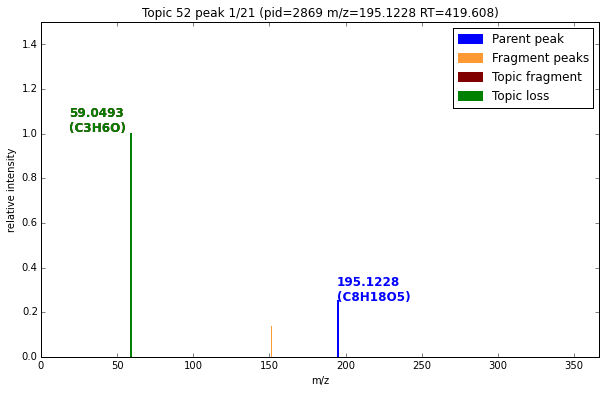

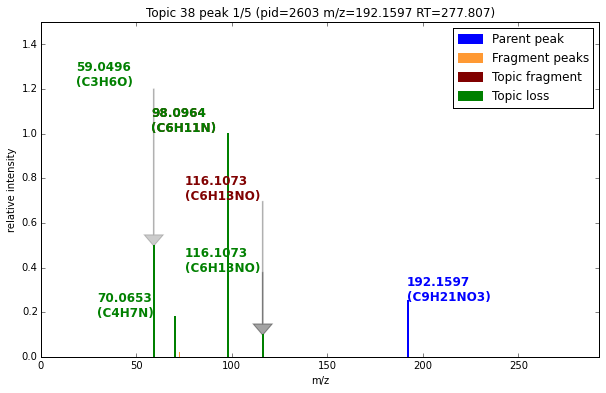

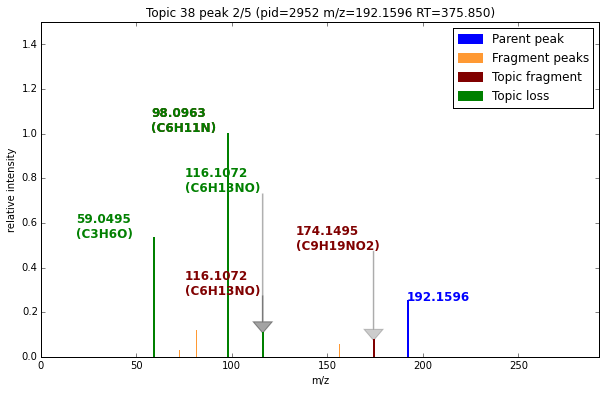

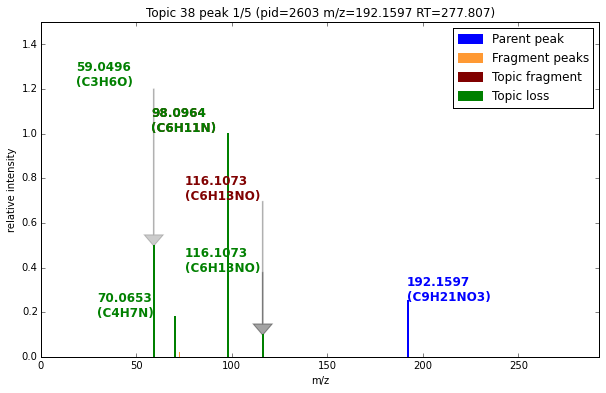

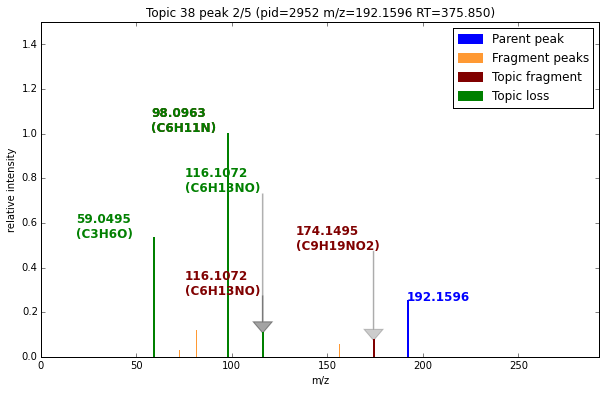

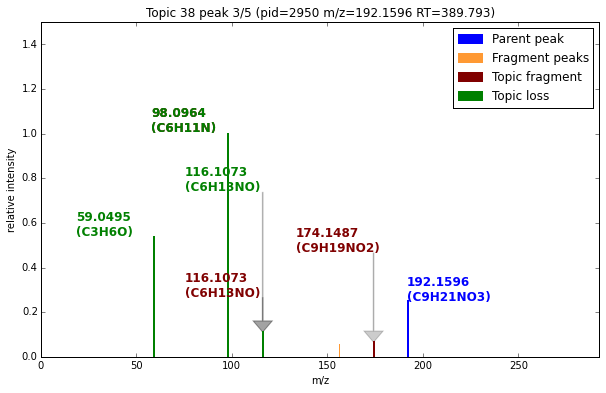

KeyboardInterrupt: 

In [19]:
interactive=True
consistency=0.0
# special_nodes = None
ms2lda.plot_lda_fragments(consistency=consistency, interactive=interactive, to_highlight=special_nodes)